In [ ]:
#------------------- DANGER ------------------- #
# DO NOT RUN ALL IT WILL DELETE THE OUTPUTS

# Univ AI-1, Higgs Boson Challenge
# Project members
- Dewang Vinchhi
- Dheeraj Anikar 
- Kunal Shinde
- Prayash Kumar

# **Details of Project**

## Higgs Boson experiment 
The ATLAS experiment and the CMS experiment recently claimed the discovery of the Higgs boson. The discovery was acknowledged by the 2013 Nobel prize in physics given to Francois Englert and Peter Higgs. This particle was theorized almost 50 years ago to have the role of giving mass to other elementary particles. It is the final ingredient of the Standard Model of particle
physics, ruling subatomic particles and forces. The experiments are running at the Large Hadron Collider (LHC) at CERN (the European Organization for Nuclear Research), Geneva, which began operating in 2009 after about 20 years of design and construction, and which will continue operating for at least the next 10 years.
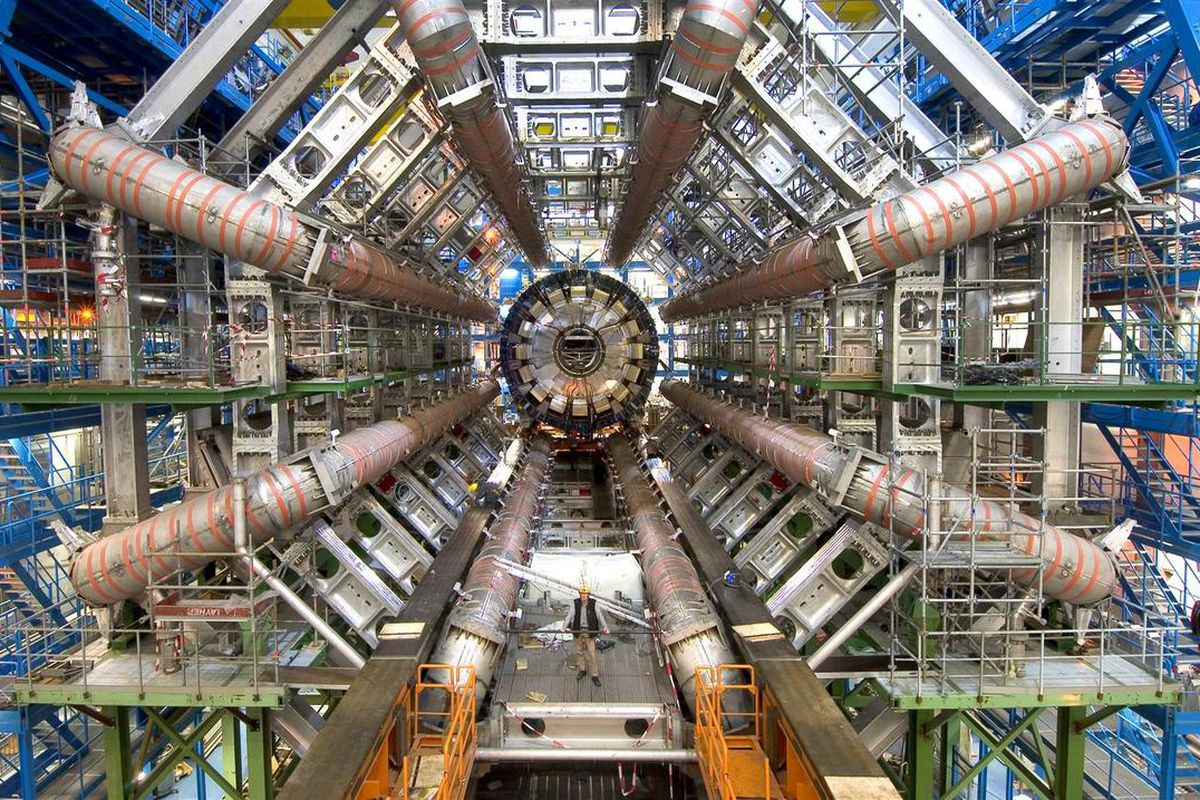


# Objective of Project
The Higgs boson has many different processes through which it can decay. When it decays, it produces other particles. In physics, a decay into specific particles is called a channel. The Higgs boson has been seen first in three distinct decay channels which are all boson pairs. One of the next important topics is to seek evidence on the decay into fermion pairs, namely tau-leptons or b-quarks, and to precisely measure their characteristics. The first evidence of the H to tau tau channel was recently reported by the ATLAS experiment. The subject of the Challenge is to try and improve on this analysis.

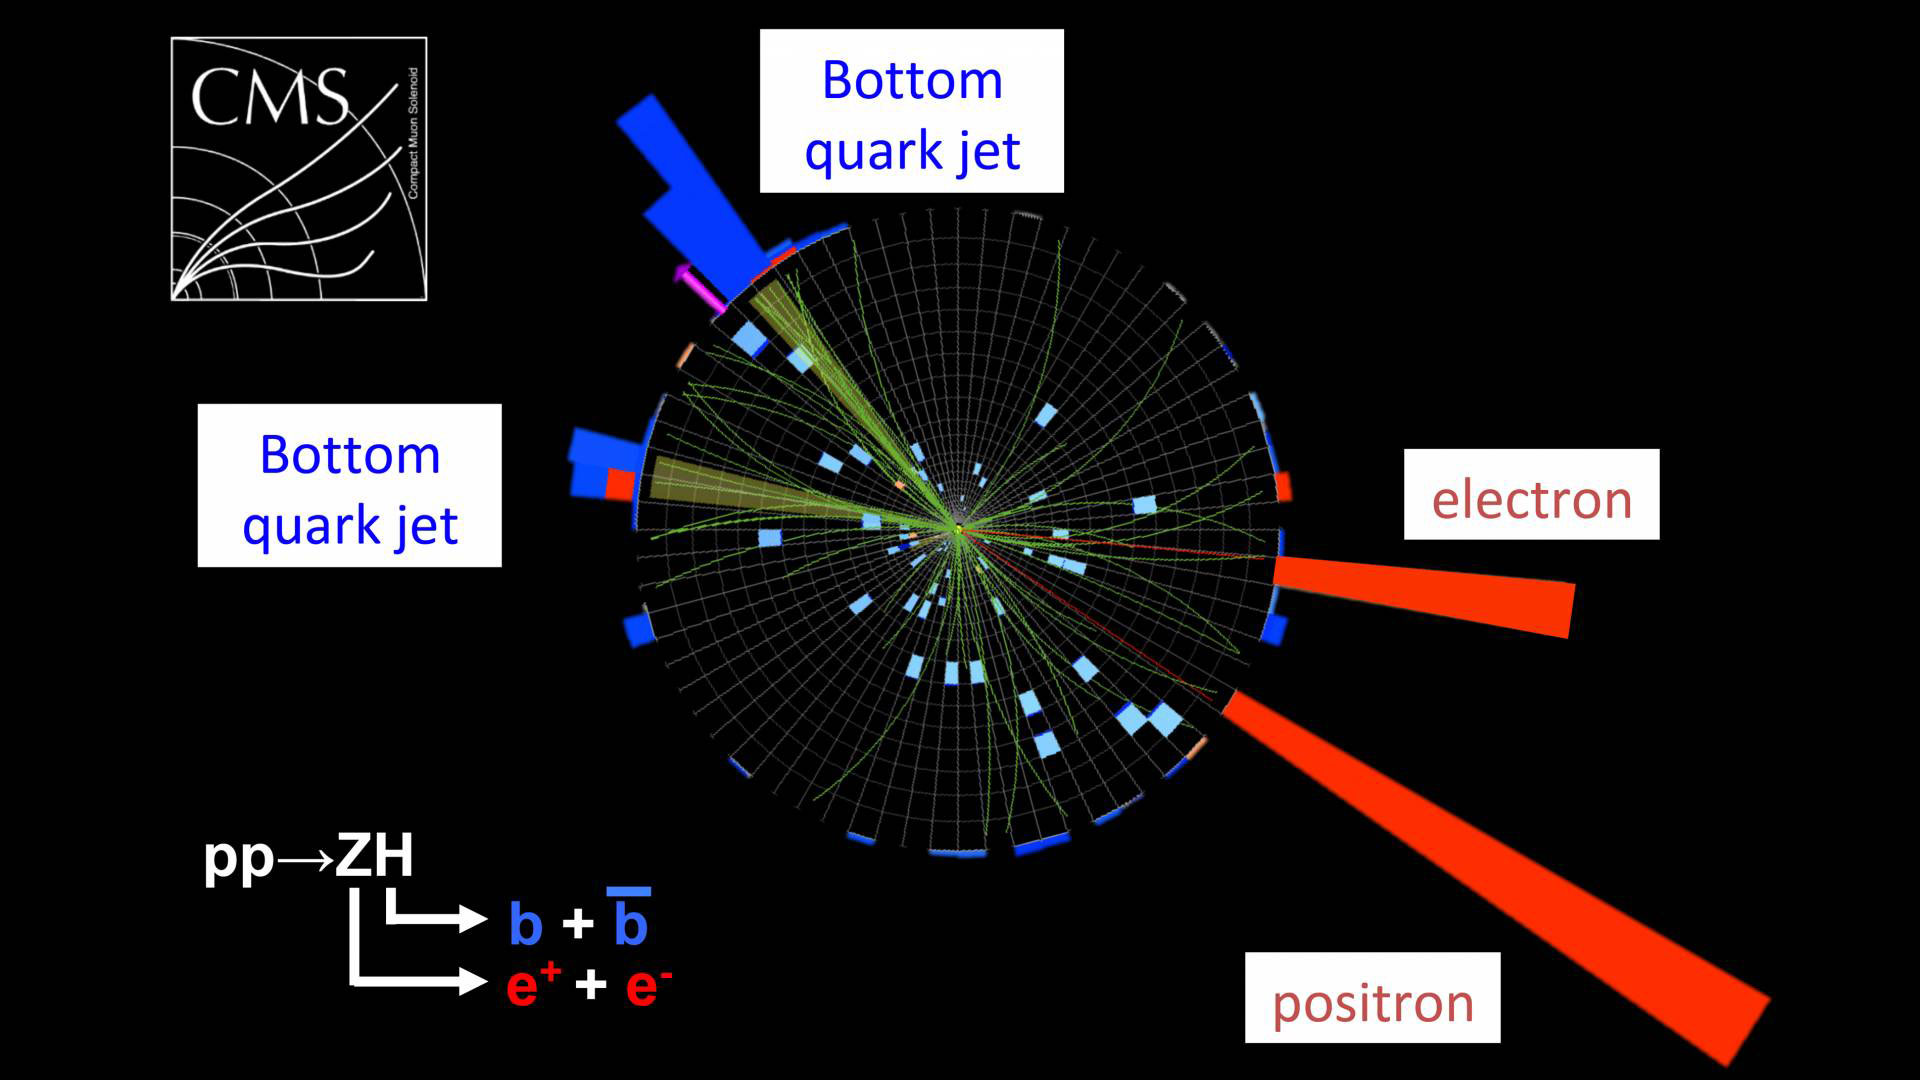

# Details about data we have
Prefix-less variables **EventId, Weight and Label** have a special role and should not be used as input to the classifier. The variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector, essentially the momenta of particles.
<br/>
<br/>
Variables prefixed with DER (for DERived) are quantities computed from the primitive features.These quantities were selected by the physicists of ATLAS in the reference document either to select regions of interest or as features for the Boosted Decision Trees used in this analysis. In
addition:
* Variables are floating point unless specified otherwise.
* All azimuthal f angles are in radian in the [􀀀p,+p[ range.
* Energy, mass, momentum are all in GeV
* All other variables are unit less.
* Variables are indicated as “may be undefined” when it can happen that they are meaningless or cannot be computed; in this case, their value is 􀀀999.0, which is outside the normal range of all variables.
* The mass of particles has not been provided, as it can safely be neglected for the Challenge.
<br/>
<br/>
For more understanding about the variables and it's meaning, refer to the document 
<a name = 'https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf'>here</a>



# Evaluation metrics
The evaluation metric is the approximate median significance (AMS):

<br/>
\text{AMS} = \sqrt{2\left((s+b+b_r) \log \left(1 + \frac{s}{b + b_r}\right)-s\right)}

where

s, b : unnormalized true positive and false positive rates, respectively,
<br/>b_r =10 is the constant regularization term,
<br/>\\(\log\\) is the natural log.

# General outline of workflow for each model
- Train model over different bootstraps
- crossvalidate
- Find feature importance
- Make any improvement necessary
- Prepare the best model after all above processes
- Evaluate over the test data using AMS.

# Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from collections import deque
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('seaborn-bright')
pd.set_option('display.max_columns', None)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading the data Files - training and testing

In [9]:
# WHILE WORKING OFFLINE
training_data = pd.read_feather('Training.ftr')
test_data = pd.read_feather('Test.ftr')

# loading data to work in google colab
# will work on Dewang's google drive
# training_data = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/univ_project/Training.ftr')
# test_data = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/univ_project/Test.ftr')

# current path
# training_data = pd.read_feather('/content/drive/MyDrive/univ_project/Submission_univ_project/Training.ftr')
# test_data = pd.read_feather('/content/drive/MyDrive/univ_project/Submission_univ_project/Test.ftr')

In [ ]:
# looking at the value count of labels
training_data['Label'].value_counts()

b    164333
s     85667
Name: Label, dtype: int64

# Data Cleaning

## Checking for null values

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float32
 2   DER_mass_transverse_met_lep  250000 non-null  float32
 3   DER_mass_vis                 250000 non-null  float32
 4   DER_pt_h                     250000 non-null  float32
 5   DER_deltaeta_jet_jet         250000 non-null  float32
 6   DER_mass_jet_jet             250000 non-null  float32
 7   DER_prodeta_jet_jet          250000 non-null  float32
 8   DER_deltar_tau_lep           250000 non-null  float32
 9   DER_pt_tot                   250000 non-null  float32
 10  DER_sum_pt                   250000 non-null  float32
 11  DER_pt_ratio_lep_tau         250000 non-null  float32
 12  DER_met_phi_centrality       250000 non-null  float32
 13 

### Observation - There are no null values

## Looking at the Training Datafranme

In [ ]:
training_data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470001,51.654999,97.827003,27.980000,0.91,124.710999,2.666,3.064,41.928001,197.759995,1.582,1.396,0,32.638000,1.017,0.381,51.625999,2.273,-2.414,16.823999,-0.277,258.733002,2,67.434998,2.150,0.444,46.062,1.24,-2.475,113.497002,0.002653,s
1,100001,160.936996,68.767998,103.235001,48.146000,-999.00,-999.000000,-999.000,3.473,2.078000,125.156998,0.879,1.414,-999,42.014000,2.039,-3.011,36.917999,0.501,0.103,44.703999,-1.916,164.546005,1,46.226002,0.725,1.158,-999.000,-999.00,-999.000,46.226002,2.233584,b
2,100002,-999.000000,162.171997,125.953003,35.634998,-999.00,-999.000000,-999.000,3.148,9.336000,197.813995,3.776,1.414,-999,32.153999,-0.705,-2.093,121.408997,-0.953,1.052,54.283001,-2.186,260.414001,1,44.250999,2.053,-2.028,-999.000,-999.00,-999.000,44.250999,2.347389,b
3,100003,143.904999,81.417000,80.943001,0.414000,-999.00,-999.000000,-999.000,3.310,0.414000,75.968002,2.354,-1.285,-999,22.646999,-1.655,0.010,53.320999,-0.522,-3.100,31.082001,0.060,86.061996,0,-999.000000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000000,5.446378,b
4,100004,175.863998,16.915001,134.804993,16.405001,-999.00,-999.000000,-999.000,3.891,16.405001,57.983002,1.056,-1.385,-999,28.209000,-2.197,-2.231,29.774000,0.798,1.569,2.723000,-0.871,53.131001,0,-999.000000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000000,6.245333,b


## Which columns are categorical and which are numerical
From observing the above DataFrame we come in to conclusion that there is only 1 feature that is categorical - 'PRI_jet_num' - 
This is also given in documentation.

In [ ]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
EventId,250000.0,224999.500000,72168.927986,100000.000000,162499.750000,224999.500000,287499.250000,349999.000000
DER_mass_MMC,250000.0,-49.023079,406.345673,-999.000000,78.100748,105.012001,130.606251,1192.026001
DER_mass_transverse_met_lep,250000.0,49.239811,35.344887,0.000000,19.240999,46.523998,73.598000,690.075012
DER_mass_vis,250000.0,81.181976,40.828690,6.329000,59.388750,73.751999,92.259003,1349.350952
DER_pt_h,250000.0,57.895962,63.655682,0.000000,14.068750,38.467499,79.168999,2834.999023
DER_deltaeta_jet_jet,250000.0,-708.420593,454.480591,-999.000000,-999.000000,-999.000000,0.490000,8.503000
DER_mass_jet_jet,250000.0,-601.237061,657.972290,-999.000000,-999.000000,-999.000000,83.445999,4974.979004
DER_prodeta_jet_jet,250000.0,-709.356689,453.019867,-999.000000,-999.000000,-999.000000,-4.593000,16.690001
DER_deltar_tau_lep,250000.0,2.373100,0.782911,0.208000,1.810000,2.491500,2.961000,5.684000
DER_pt_tot,250000.0,18.917334,22.273493,0.000000,2.841000,12.315500,27.591000,2834.999023


### Observation
- There are unusual 999 values. Meaning of 999 is the value is meaningless or cannot be computed.
- EventId - not necessary for training. BUT NEEDED FOR EVALUATION USING AMS
- There are extreme values in a few features
    - 'DER_mass_MMC' - a big gap between 75% and maximum
    - 'DER_mass_transverse_met_lep' - a big gap between 75% and maximum
    - 'DER_mass_vis' - a big gap between 75% and maximum
    - 'DER_pt_h' - a big gap between 75% and maximum
    - 'DER_prodeta_jet_jet' - a big gap between 75% and maximum
    - 'DER_pt_tot' - a big gap between 75% and maximum
- 'Label' - this has imbalanced classes


### How to deal with 999 values?
- Replacing them with np.nan
- This will help in the way that we are not manipulating data

In [ ]:
# Encoding the label column with 0 and 1
# 's' - Signals - 1
# 'b' - background - 0
label_dict = {'s':1, 'b':0}

def enc(val):
    if val == 's':
        return 1
    else:
        return 0
# droppging the two columns 
# event id is useless in predictions
# Weight columns is not to be used in predictions
true_solutions = training_data[['Weight','Label','EventId']].set_index('EventId')
true_solutions['Label'] = true_solutions['Label'].map(label_dict)


data_1 = training_data.drop(['Weight' ] , axis=1).copy()

data_1['Label'] =training_data.loc[:,'Label'].apply(enc)

data_1 = data_1.set_index('EventId')


print("Frequency of signals and background noise")
print("'s' = 1\n'b' = 0\n")
print(data_1['Label'].value_counts())
print("Total values in 'Label' column = ", len(data_1['Label']))

# data_1[data_1.index.duplicated()]

# setting 'EventId' as index
test_data_1 = test_data.set_index('EventId').copy()

Frequency of signals and background noise
's' = 1
'b' = 0

0    164333
1     85667
Name: Label, dtype: int64
Total values in 'Label' column =  250000


### Observation
- we have imbalanced labels

REPLACING -999 VALUES IN TEST DATA AND TRAINIG DATA BOTH, THEN LOOKING AT FIRST 5 ROWS

In [ ]:
# replacing -999 in data_1 with np.nan

data_1 = data_1.replace(-999, np.nan)

# replacing -999 with np.nan in test data
test_data_1 = test_data_1.replace(-999, np.nan)

data_1.head(10)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
EventId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,138.470001,51.654999,97.827003,27.980000,0.910,124.710999,2.666,3.064,41.928001,197.759995,1.582,1.396,0.0,32.638000,1.017,0.381,51.625999,2.273,-2.414,16.823999,-0.277,258.733002,2,67.434998,2.150,0.444,46.062000,1.240,-2.475,113.497002,1
100001,160.936996,68.767998,103.235001,48.146000,NaN,NaN,NaN,3.473,2.078000,125.156998,0.879,1.414,NaN,42.014000,2.039,-3.011,36.917999,0.501,0.103,44.703999,-1.916,164.546005,1,46.226002,0.725,1.158,NaN,NaN,NaN,46.226002,0
100002,NaN,162.171997,125.953003,35.634998,NaN,NaN,NaN,3.148,9.336000,197.813995,3.776,1.414,NaN,32.153999,-0.705,-2.093,121.408997,-0.953,1.052,54.283001,-2.186,260.414001,1,44.250999,2.053,-2.028,NaN,NaN,NaN,44.250999,0
100003,143.904999,81.417000,80.943001,0.414000,NaN,NaN,NaN,3.310,0.414000,75.968002,2.354,-1.285,NaN,22.646999,-1.655,0.010,53.320999,-0.522,-3.100,31.082001,0.060,86.061996,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000000,0
100004,175.863998,16.915001,134.804993,16.405001,NaN,NaN,NaN,3.891,16.405001,57.983002,1.056,-1.385,NaN,28.209000,-2.197,-2.231,29.774000,0.798,1.569,2.723000,-0.871,53.131001,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
100005,89.744003,13.550000,59.148998,116.344002,2.636,284.584015,-0.540,1.362,61.618999,278.876007,0.588,0.479,0.0,53.651001,0.371,1.329,31.565001,-0.884,1.857,40.735001,2.237,282.848999,3,90.546997,-2.412,-0.653,56.165001,0.224,3.106,193.660004,0
100006,148.753998,28.862000,107.781998,106.129997,0.733,158.358994,0.113,2.941,2.545000,305.967010,3.371,1.393,0.0,28.850000,1.113,2.409,97.239998,0.675,-0.966,38.421001,-1.443,294.074005,2,123.010002,0.864,1.450,56.867001,0.131,-2.767,179.876999,1
100007,154.916000,10.418000,94.713997,29.169001,NaN,NaN,NaN,2.897,1.526000,138.177994,0.365,-1.305,NaN,78.800003,0.654,1.547,28.740000,0.506,-1.347,22.275000,-1.761,187.298996,1,30.638000,-0.715,-1.724,NaN,NaN,NaN,30.638000,1
100008,105.594002,50.558998,100.988998,4.288000,NaN,NaN,NaN,2.904,4.288000,65.333000,0.675,-1.366,NaN,39.007999,2.433,-2.532,26.325001,0.210,1.884,37.791000,0.024,129.804001,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0


MAKING A PREDICTOR AND RESPONSE VARIABLE SEPARATELY

In [ ]:
y = data_1['Label']

X = data_1.drop('Label', axis=1)

MAKING A HISTOGRAM OF ALL THE COLUMNS TO LOOK AT THE DISTRIBUTION

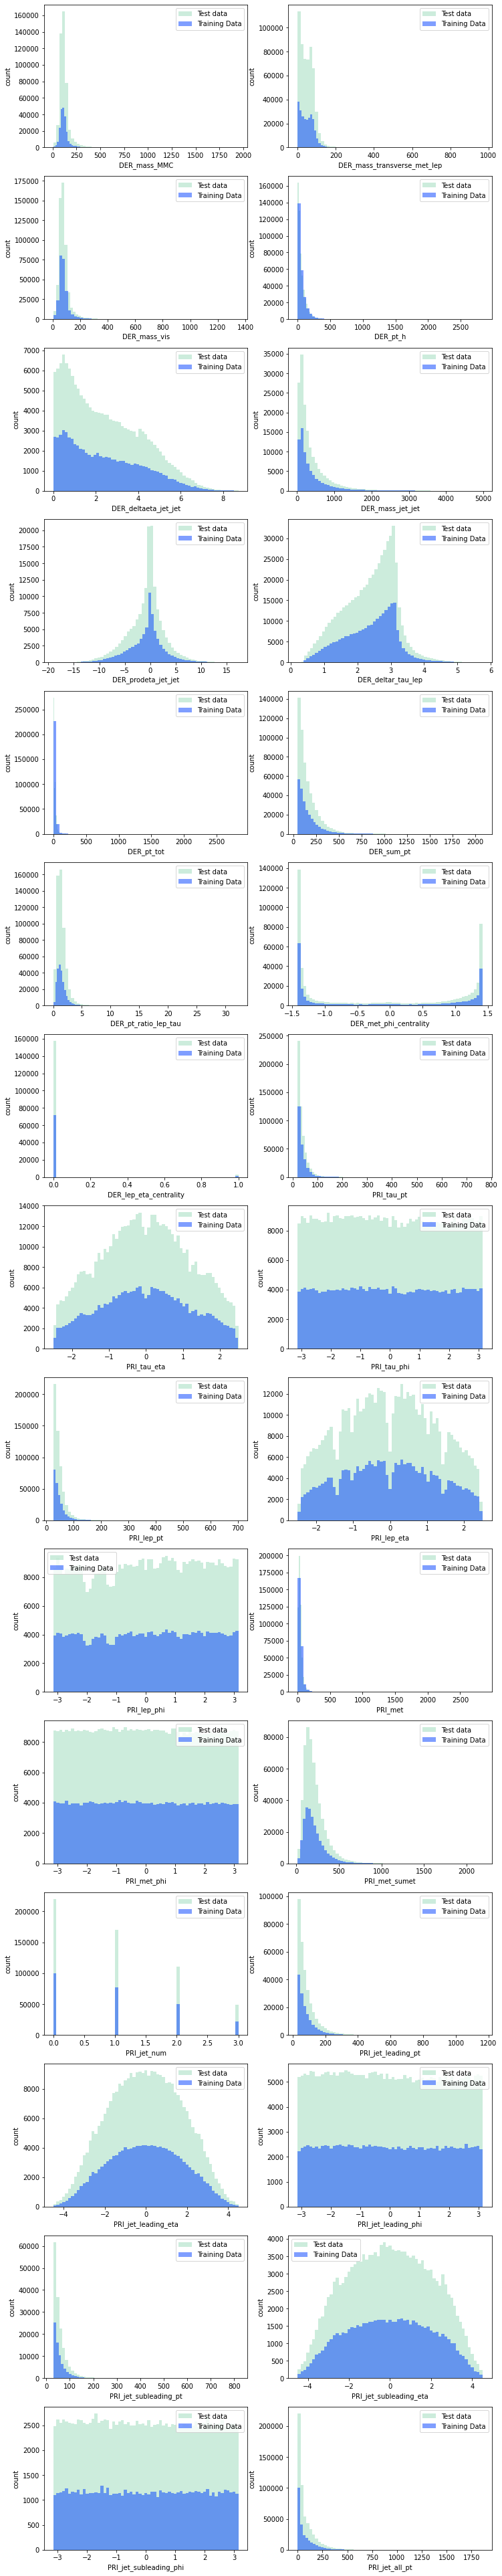

In [ ]:
# Plotting histograms and looking at the distribution of different variables

plt.subplots(15,2, figsize=(12,70))

for i in range(30):
    ax = plt.subplot(15,2,i+1)
    
    plt_data = X.iloc[:, i]
    
    # number of bins is k=n^(1/3)
    bins_num = round((plt_data.shape[0])**(1/3))
    
    ax.hist(x = test_data_1.iloc[:, i],
           bins = bins_num,
           alpha=0.3, color='#59C18D', label='Test data')
    
    ax.hist(x = plt_data, 
            bins = bins_num,
           label='Training Data',
           alpha=0.5)
    
    ax.legend()
    # ax.set_xlim(np.min(plt_data)-2, np.max(plt_data)+2)
    ax.set_xlabel( X.columns[i] )
    ax.set_ylabel( 'count' )

# plt.savefig("Distribution plots.jpg")
plt.savefig("histogram_distribution_summary.png")
plt.show()


WE NEED TO DO THE SCALING IN THE DATA. WE HAVE OPTIONS TO DO
- TAKE LOG
- DO NORMALIZATION
- DO STANDARD SCALING.

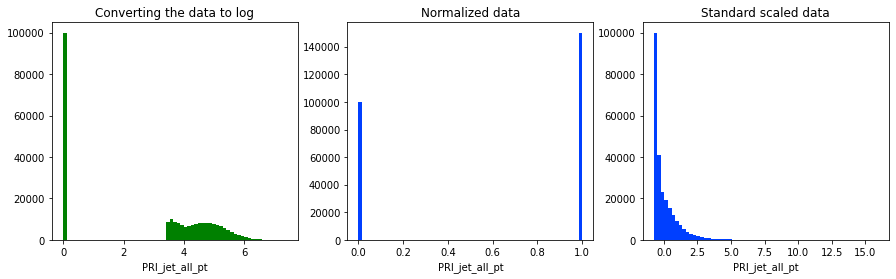

In [ ]:
# Checking out of Standard scaling, Normalization and log1p which gives right distribution

from sklearn.preprocessing import StandardScaler, Normalizer


# make a figure and axes to plot
f, ax = plt.subplots(1,3, figsize=(15,4))


# first axes with log values
ax[0].hist(np.log(X['PRI_jet_all_pt']+1), color='green', bins=63)
ax[0].set_xlabel('PRI_jet_all_pt')
ax[0].set_title('Converting the data to log')


# second axes with normalized values
sc= Normalizer()

scaler = StandardScaler()
scaled = scaler.fit_transform(X[['PRI_jet_all_pt']])

sc_ = sc.fit_transform(X[['PRI_jet_all_pt']])

ax[1].hist(sc_, bins=63)
ax[1].set_xlabel('PRI_jet_all_pt')
ax[1].set_title('Normalized data')


# 3rd axes with Standardized values
ax[2].hist(scaled, bins=63)
ax[2].set_xlabel('PRI_jet_all_pt')
ax[2].set_title('Standard scaled data')
plt.show()

-------------------------------------------------------

VISUALIZING THE CORRELATION MATRIX USING SEABORN HEATMAP

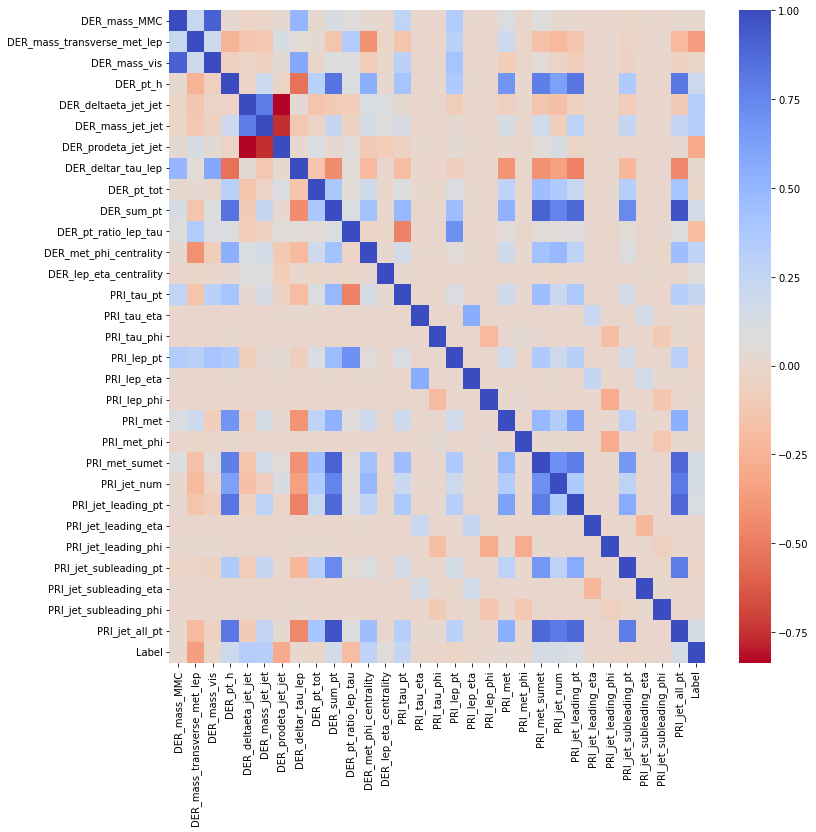

In [ ]:
plt.subplots(figsize=(12,12))
dataplot = sbn.heatmap(data_1.corr(), cmap="coolwarm_r",)
plt.savefig('heatmap_corr.png')

## Separating the data according to the number of jets used

We observe that the null values (previously -999) is related to the number of jets being used. So we will be making a seperate datasets for training a model.

In [ ]:
# there are 4 jets - 0,1,2,3,

# helper function to create a dictionary of 
# 4 datasets corresponding to 4 jets
def separate_data(some_data, name):
    """
    separate_data(some_data)

    return ds_dict

    Take the Dataframe and separate it by the jet number

    It will return a dictionary.
    Key is the vaiable name of Dataframe and 
    Value is the DataFrame
    """
    ds_dict = dict()
    for n in range(4):
        ds_dict[f'{name}_ds_jet{n}'] = some_data[some_data[f'PRI_jet_num']==n]
        ds_dict[f'{name}_ds_jet{n}'] = ds_dict[f'{name}_ds_jet{n}'].drop(['PRI_jet_num'], axis=1)
    
    return ds_dict


# Helper function to drop null columns
def drop_col_na(data_dict):
    """
    drop_col_na(data_dict)

    return data_dict

    It takes a dictionary which holds the 4 data sets and drops all the columns which has 
    Null values. This will drop only those columns which has all the elements
    as null or Nan.
    """
    for ds in data_dict:
        data_dict[ds] = data_dict[ds].dropna(axis=1, how='all')
    return data_dict


train_ds_list = separate_data(some_data=data_1, name='train')

print("Following are the keys of training dataset just created: -")
train_ds_list.keys()

Following are the keys of training dataset just created: -


dict_keys(['train_ds_jet0', 'train_ds_jet1', 'train_ds_jet2', 'train_ds_jet3'])

**LOOKING AT THE INFO OF THE DATASETS ONE BY ONE**

In [ ]:
# Taking a look at the info of first training dataset
train_ds_list['train_ds_jet0'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99913 entries, 100003 to 349999
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DER_mass_MMC                 73790 non-null  float32
 1   DER_mass_transverse_met_lep  99913 non-null  float32
 2   DER_mass_vis                 99913 non-null  float32
 3   DER_pt_h                     99913 non-null  float32
 4   DER_deltaeta_jet_jet         0 non-null      float32
 5   DER_mass_jet_jet             0 non-null      float32
 6   DER_prodeta_jet_jet          0 non-null      float32
 7   DER_deltar_tau_lep           99913 non-null  float32
 8   DER_pt_tot                   99913 non-null  float32
 9   DER_sum_pt                   99913 non-null  float32
 10  DER_pt_ratio_lep_tau         99913 non-null  float32
 11  DER_met_phi_centrality       99913 non-null  float32
 12  DER_lep_eta_centrality       0 non-null      float64
 13  PRI_tau_pt

In [ ]:
# making an empty list to store the naMes of null columns
drop_col_train_j0 = deque()

# looping through the columns of first dataset
for col in train_ds_list['train_ds_jet0'].columns:
    # if all values in a column are null only then is will it be added
    if train_ds_list['train_ds_jet0'][col].isnull().all():
        drop_col_train_j0.append(col)

print(f"Following are the columns with all null values in dataset for jet 0: \n")
for col in drop_col_train_j0:
    print(col)

Following are the columns with all null values in dataset for jet 0: 

DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi


In [ ]:
# Taking a look at the info of first training dataset
train_ds_list['train_ds_jet1'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77544 entries, 100001 to 349997
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DER_mass_MMC                 69982 non-null  float32
 1   DER_mass_transverse_met_lep  77544 non-null  float32
 2   DER_mass_vis                 77544 non-null  float32
 3   DER_pt_h                     77544 non-null  float32
 4   DER_deltaeta_jet_jet         0 non-null      float32
 5   DER_mass_jet_jet             0 non-null      float32
 6   DER_prodeta_jet_jet          0 non-null      float32
 7   DER_deltar_tau_lep           77544 non-null  float32
 8   DER_pt_tot                   77544 non-null  float32
 9   DER_sum_pt                   77544 non-null  float32
 10  DER_pt_ratio_lep_tau         77544 non-null  float32
 11  DER_met_phi_centrality       77544 non-null  float32
 12  DER_lep_eta_centrality       0 non-null      float64
 13  PRI_tau_pt

In [ ]:
# making an empty list to store the naes of null columns
drop_col_train_j1 = deque()

# looping through the columns of second dataset
for col in train_ds_list['train_ds_jet1'].columns:
    # if all values in a column are null only then is will it be added
    if train_ds_list['train_ds_jet1'][col].isnull().all():
        drop_col_train_j1.append(col)

print(f"Following are the columns with all null values in dataset for jet 1: \n")
for col in drop_col_train_j1:
    print(col)

Following are the columns with all null values in dataset for jet 1: 

DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi


In [ ]:
train_ds_list['train_ds_jet2'].info()

# There are no null columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50379 entries, 100000 to 349994
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DER_mass_MMC                 47427 non-null  float32
 1   DER_mass_transverse_met_lep  50379 non-null  float32
 2   DER_mass_vis                 50379 non-null  float32
 3   DER_pt_h                     50379 non-null  float32
 4   DER_deltaeta_jet_jet         50379 non-null  float32
 5   DER_mass_jet_jet             50379 non-null  float32
 6   DER_prodeta_jet_jet          50379 non-null  float32
 7   DER_deltar_tau_lep           50379 non-null  float32
 8   DER_pt_tot                   50379 non-null  float32
 9   DER_sum_pt                   50379 non-null  float32
 10  DER_pt_ratio_lep_tau         50379 non-null  float32
 11  DER_met_phi_centrality       50379 non-null  float32
 12  DER_lep_eta_centrality       50379 non-null  float64
 13  PRI_tau_pt

In [ ]:
train_ds_list['train_ds_jet3'].info()

# There are no null columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22164 entries, 100005 to 349993
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DER_mass_MMC                 20687 non-null  float32
 1   DER_mass_transverse_met_lep  22164 non-null  float32
 2   DER_mass_vis                 22164 non-null  float32
 3   DER_pt_h                     22164 non-null  float32
 4   DER_deltaeta_jet_jet         22164 non-null  float32
 5   DER_mass_jet_jet             22164 non-null  float32
 6   DER_prodeta_jet_jet          22164 non-null  float32
 7   DER_deltar_tau_lep           22164 non-null  float32
 8   DER_pt_tot                   22164 non-null  float32
 9   DER_sum_pt                   22164 non-null  float32
 10  DER_pt_ratio_lep_tau         22164 non-null  float32
 11  DER_met_phi_centrality       22164 non-null  float32
 12  DER_lep_eta_centrality       22164 non-null  float64
 13  PRI_tau_pt

### **Observation**

- The data set has null values for columns that are directly related to number of jets.
- There is one common column/feature = DER mass MMC - has missing values (undfined). As mentioned in the documentation - The estimated mass m H of the Higgs boson candidate, obtained through a probabilistic phase space integration (may be undefined if the topology of the event is too far from the expected topology)

- In the documentation too it is mentioned that jet 0, 1, 2 have few variables that are useless or can't be measured.

**Decision**

- We will make 4 datasets and fit training model separately on them and then do the evaluation
- How to deal with missing values? - We are dropping the rows that has missing (-999, undefined previously) values because 
    - We have enough number of observation to make good model.
    - ML model cannot handle nan values.

In [ ]:
# DROPPING ALL THE COLUMN WITH NULL VALUES

# using the function defined earliar to remove the NULL COLUMNS
train_ds_list = drop_col_na(data_dict=train_ds_list)

# looking at the info after dropping null columns
train_ds_list['train_ds_jet0'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99913 entries, 100003 to 349999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DER_mass_MMC                 73790 non-null  float32
 1   DER_mass_transverse_met_lep  99913 non-null  float32
 2   DER_mass_vis                 99913 non-null  float32
 3   DER_pt_h                     99913 non-null  float32
 4   DER_deltar_tau_lep           99913 non-null  float32
 5   DER_pt_tot                   99913 non-null  float32
 6   DER_sum_pt                   99913 non-null  float32
 7   DER_pt_ratio_lep_tau         99913 non-null  float32
 8   DER_met_phi_centrality       99913 non-null  float32
 9   PRI_tau_pt                   99913 non-null  float32
 10  PRI_tau_eta                  99913 non-null  float32
 11  PRI_tau_phi                  99913 non-null  float32
 12  PRI_lep_pt                   99913 non-null  float32
 13  PRI_lep_et

----------------------------------------------------------------------

Looking at the rows which has null values.


In [ ]:
# looking at the rows which has null values.
train_ds_list['train_ds_jet0'][train_ds_list['train_ds_jet0'].isna().any(axis=1)].head(5)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_all_pt,Label
EventId,,,,,,,,,,,,,,,,,,,,
100010,NaN,86.239998,79.692001,27.201,2.338,27.201,81.734001,1.750,-1.412,29.718000,-0.866,2.878,52.015999,0.126,-1.288,51.276001,0.688,250.177994,0.0,0
100014,NaN,109.412003,14.398000,17.323,0.472,17.323,62.564999,1.774,-0.272,22.552000,1.389,1.340,40.013000,1.856,1.412,75.196999,-1.583,198.615997,0.0,0
100018,NaN,85.185997,68.827003,5.042,2.116,5.042,71.443001,1.558,-1.351,27.931000,1.175,2.356,43.512001,2.332,0.584,44.698002,-2.033,151.815994,0.0,0
100019,NaN,88.766998,115.057999,15.337,2.879,15.337,58.210999,0.875,-1.395,31.046000,1.380,0.451,27.165001,-1.486,0.724,72.981003,-2.577,115.144997,-0.0,0
100020,NaN,89.705002,41.764999,18.437,1.395,18.437,57.157001,1.082,-1.178,27.452999,1.580,2.510,29.704000,0.341,1.869,67.908997,-1.169,225.139008,0.0,0


### How to deal with these rows?
- drop them

In [ ]:
for ds_name in train_ds_list:
    train_ds_list[ds_name] = train_ds_list[ds_name].dropna(axis=0, how='any')

# The same process is performed for all datasets so we are looking at only one dataset
train_ds_list['train_ds_jet0'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73790 entries, 100003 to 349998
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DER_mass_MMC                 73790 non-null  float32
 1   DER_mass_transverse_met_lep  73790 non-null  float32
 2   DER_mass_vis                 73790 non-null  float32
 3   DER_pt_h                     73790 non-null  float32
 4   DER_deltar_tau_lep           73790 non-null  float32
 5   DER_pt_tot                   73790 non-null  float32
 6   DER_sum_pt                   73790 non-null  float32
 7   DER_pt_ratio_lep_tau         73790 non-null  float32
 8   DER_met_phi_centrality       73790 non-null  float32
 9   PRI_tau_pt                   73790 non-null  float32
 10  PRI_tau_eta                  73790 non-null  float32
 11  PRI_tau_phi                  73790 non-null  float32
 12  PRI_lep_pt                   73790 non-null  float32
 13  PRI_lep_et

**CLEANING THE TEST DATA THE SAME WAY WE DID FOR TRAINING DATA.**

In [ ]:
# cleaning the test data same way

test_ds_dict = separate_data(some_data=test_data_1, name='test')
test_ds_dict = drop_col_na(data_dict=test_ds_dict)

print("The names of data set separated from test data are\n", test_ds_dict.keys())

for ds_name in test_ds_dict:
    test_ds_dict[ds_name] = test_ds_dict[ds_name].dropna(axis=0, how='any')

The names of data set separated from test data are
 dict_keys(['test_ds_jet0', 'test_ds_jet1', 'test_ds_jet2', 'test_ds_jet3'])


LOOKING AT THE FIRST DATASET IN TEST DATA

In [ ]:
test_ds_dict['test_ds_jet0'].head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_all_pt
EventId,,,,,,,,,,,,,,,,,,,
350002,117.793999,56.226002,96.358002,4.137,2.755,4.137,97.599998,1.096,-1.408,46.563999,-0.298,3.079,51.035999,-0.548,0.336,19.461000,-1.868,111.504997,0.0
350003,135.860992,30.604000,97.288002,9.104,2.811,9.104,94.112000,0.819,-1.382,51.741001,0.388,-1.408,42.370998,-0.295,2.148,25.131001,1.172,164.707001,0.0
350005,95.709000,94.167999,66.279999,14.719,3.065,14.719,70.259003,2.465,-1.351,20.275999,-1.212,2.289,49.983002,-0.630,-0.720,44.584999,2.566,86.128998,0.0
350008,70.958000,66.329002,60.950001,0.758,2.370,0.758,66.572998,1.593,-1.380,25.676001,1.513,0.095,40.896999,1.132,2.434,30.277000,-1.389,102.087997,-0.0
350011,143.089005,105.195000,106.832001,23.149,2.611,23.149,112.841003,2.120,-1.038,36.165001,1.233,2.097,76.676003,1.918,-0.422,36.084999,2.742,162.848999,0.0


In [ ]:
print("Shape of first dataset in the test dataset is: -") 
train_ds_list['train_ds_jet0'].shape

Shape of first dataset in the test dataset is: -


(73790, 20)

**MAKING BOPLOT TO OBSERVE THE DISTRIBUTION OF VALUES OF ALL COLUMNS FOR TWO LABELS**

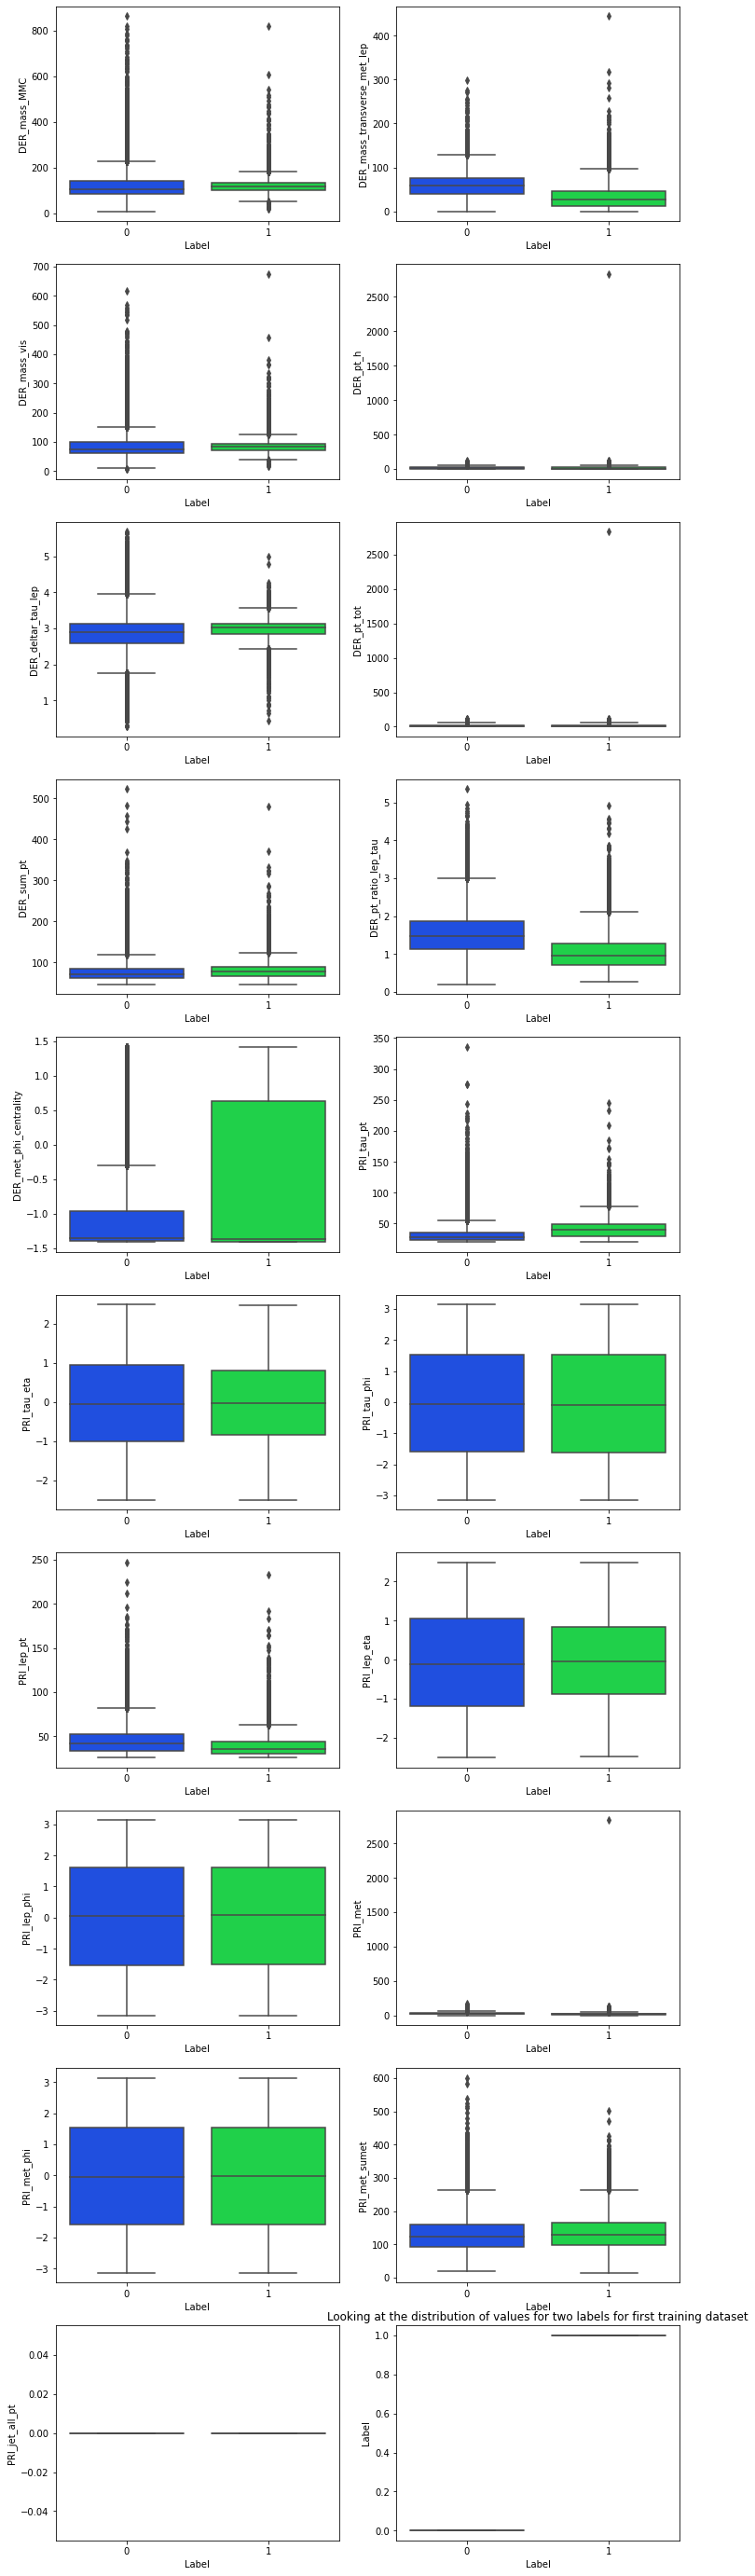

In [ ]:
f, ax = plt.subplots(10,2, figsize=(12, 50))
for i, col in enumerate(train_ds_list['train_ds_jet0'].columns):
    ax=plt.subplot(10,2, i+1)
    sbn.boxplot( data = train_ds_list['train_ds_jet0'] ,
                y=col, x='Label',
                ax=ax)
plt.title("Looking at the distribution of values for two labels for first training dataset")
plt.show()

### Separating X (predictors) and y (response variable) from training data.

In [ ]:
# storing y as dataframe because we will need indexes for evaluation

# making an empty dictionary
y_dict = dict()

# looping through the train dataset dictionary
# Though there is 'list' in variable name it is dictionary
for n, ds in enumerate(train_ds_list):
    y_dict[f'y_jet{n}'] = train_ds_list[ds][['Label']]

# y_dict['y_jet0'][:5]


# making an empty dictionary to store training X
X_dict = dict()

for n, ds in enumerate(train_ds_list):
    X_dict[f'X_jet{n}'] = train_ds_list[ds].drop('Label', axis=1)

# X_dict['X_jet0'].head()

In [ ]:
print("So Lets mention what we have right now\n")
print("'y' sets of dataframe training sets")
print(y_dict.keys(), '\n')
print("'X' sets of dataframe training sets")
print(X_dict.keys(), '\n')
print('-'*50)
print('For test data we have\n')
print("Testing sets Dataframe only")
print(test_ds_dict.keys())

So Lets mention what we have right now

'y' sets of dataframe training sets
dict_keys(['y_jet0', 'y_jet1', 'y_jet2', 'y_jet3']) 

'X' sets of dataframe training sets
dict_keys(['X_jet0', 'X_jet1', 'X_jet2', 'X_jet3']) 

--------------------------------------------------
For test data we have

Testing sets Dataframe only
dict_keys(['test_ds_jet0', 'test_ds_jet1', 'test_ds_jet2', 'test_ds_jet3'])


### Doing standard scaling
From visual inspection the features appear to be normaly distributed (with skew) and also different features are in different ranges. To limit the features in the same range, we opted for standard scaling.

#### Why are we doing standard scaling?
**Answer**

**StandardScaler** : It transforms the data in such a manner that it has mean as 0 and standard deviation as 1. In short, it standardizes the data. Standardization is useful for data which has negative values. It arranges the data in a standard normal distribution. It is more useful in classification than regression

**Normalizer** : It squeezes the data between 0 and 1. It performs normalization. Due to the decreased range and magnitude, the gradients in the training process do not explode and you do not get higher values of loss. Is more useful in regression than classification

In [ ]:
# scaling training data
sc1 = StandardScaler()
# scaled_train_data = pd.DataFrame(sc1.fit_transform(X[scale_columns]), columns=scale_columns)
for ds in X_dict:
    X_dict[ds] = pd.DataFrame(sc1.fit_transform(X_dict[ds]), 
                              columns = X_dict[ds].columns,
                              index=X_dict[ds].index)


LOOKING AT THE SUMMARY STATISTIC OF FIRST DATASET IN THE DICTIONARY AFTER DOING STANDARD SCALING

In [ ]:
X_dict['X_jet0'].describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
DER_mass_MMC,73790.0,0.0,1.0,-2.1570,-0.5880,-0.1781,0.3231,14.3572
DER_mass_transverse_met_lep,73790.0,0.0,1.0,-1.6945,-0.8007,0.0131,0.6986,13.5396
DER_mass_vis,73790.0,0.0,1.0,-2.2436,-0.5763,-0.2080,0.2834,16.7716
DER_pt_h,73790.0,0.0,1.0,-0.8344,-0.6901,-0.3696,0.5741,158.7487
DER_deltar_tau_lep,73790.0,0.0,1.0,-5.2798,-0.4430,0.1090,0.4816,5.6125
DER_pt_tot,73790.0,0.0,1.0,-0.8344,-0.6901,-0.3696,0.5741,158.7487
DER_sum_pt,73790.0,-0.0,1.0,-1.3917,-0.6513,-0.1855,0.4058,19.6192
DER_pt_ratio_lep_tau,73790.0,-0.0,1.0,-2.0555,-0.7590,-0.1352,0.6089,6.9309
DER_met_phi_centrality,73790.0,-0.0,1.0,-0.6102,-0.6007,-0.5558,0.0014,2.0892
PRI_tau_pt,73790.0,0.0,1.0,-1.0149,-0.7285,-0.2888,0.4589,20.6366


**Doing standard scaling on test data**

In [ ]:
sc2 = StandardScaler()

for ds in test_ds_dict:
    test_ds_dict[ds] = pd.DataFrame(sc2.fit_transform(test_ds_dict[ds]), 
                        columns= test_ds_dict[ds].columns,
                        index = test_ds_dict[ds].index)

LOOKING AT THE SUMMARY STATISTIC OF FIRST DATASET IN THE DICTIONARY AFTER DOING STANDARD SCALING

In [ ]:
test_ds_dict['test_ds_jet0'].describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
DER_mass_MMC,162712.0,-0.0,1.0,-2.1472,-0.5940,-0.1765,0.3291,16.8322
DER_mass_transverse_met_lep,162712.0,0.0,1.0,-1.6977,-0.7950,0.0096,0.6904,16.1519
DER_mass_vis,162712.0,-0.0,1.0,-2.2116,-0.5781,-0.2056,0.2873,20.5099
DER_pt_h,162712.0,0.0,1.0,-1.0283,-0.8496,-0.4519,0.7061,10.7897
DER_deltar_tau_lep,162712.0,0.0,1.0,-5.3225,-0.4479,0.1068,0.4847,5.5016
DER_pt_tot,162712.0,0.0,1.0,-1.0283,-0.8496,-0.4519,0.7061,10.7897
DER_sum_pt,162712.0,-0.0,1.0,-1.3883,-0.6507,-0.1842,0.4037,27.8837
DER_pt_ratio_lep_tau,162712.0,-0.0,1.0,-2.1943,-0.7551,-0.1358,0.6056,7.3010
DER_met_phi_centrality,162712.0,0.0,1.0,-0.6095,-0.6000,-0.5561,0.0009,2.0876
PRI_tau_pt,162712.0,-0.0,1.0,-1.0131,-0.7237,-0.2920,0.4516,25.8853


### OBSERVATION 
- There are outliers

### Doing one hot encoding on 1 column - PRI_jet_num
- **No need** - data set is separated according to jet nums

In [ ]:
print("So Lets mention what we have right now\n")
print("'y' sets of dataframe training sets = y_dict")
print(y_dict.keys(), '\n')
print("'X' sets of dataframe training sets = X_dict")
print(X_dict.keys(), '\n')
print('-'*50)
print('For test data we have = test_ds_dict')
print("Testing sets Dataframe only")
print(test_ds_dict.keys())

So Lets mention what we have right now

'y' sets of dataframe training sets = y_dict
dict_keys(['y_jet0', 'y_jet1', 'y_jet2', 'y_jet3']) 

'X' sets of dataframe training sets = X_dict
dict_keys(['X_jet0', 'X_jet1', 'X_jet2', 'X_jet3']) 

--------------------------------------------------
For test data we have = test_ds_dict
Testing sets Dataframe only
dict_keys(['test_ds_jet0', 'test_ds_jet1', 'test_ds_jet2', 'test_ds_jet3'])


----------------------------------------------------------------------

WE ARE FURTHER DIVIDING THE TRAINING SET INTO TRAINING AND VALIDATION SETS - 80% Training size

In [ ]:
from sklearn.model_selection import train_test_split


# making 4 dictionaries to save training and validation sets
X_train_dict = dict()
X_val_dict = dict()
y_train_dict = dict()
y_val_dict = dict()

# custom_splitter
train_size = 0.8 # 80 % training size    

all_sample_idx = deque()
all_test_samples_idx = deque()

for ds in X_dict:
    idx = X_dict[ds].index
    N = len(idx)
    tr_samples = np.random.choice(idx, round(N*train_size))
    all_sample_idx.append(tr_samples)
    all_test_samples_idx.append( [v for v in idx if v not in tr_samples] )

i=0
for samples in all_sample_idx:
    # X_train
    X_train_dict[f'X_tr_j{i}'] = list(X_dict.values())[i].loc[samples,:]

    # print(predictor_train.head())
    # y_train
    y_train_dict[f'y_tr_j{i}'] = list(y_dict.values())[i].loc[samples,:]
    i+=1

i=0
for samples in all_test_samples_idx:
    # X_test
    X_val_dict[f'X_val_j{i}'] = list(X_dict.values())[i].loc[samples,:]
    # y_train
    y_val_dict[f'y_val_j{i}'] = list(y_dict.values())[i].loc[samples,:]
    i+=1

In [ ]:
print("So Lets mention what we have right now\n")
print("y - train and validation")
print("y_train_dict and y_val_dict")
print(y_train_dict.keys(), '\n')
print(y_val_dict.keys(), '\n')

print("X - train and validation")
print(X_train_dict.keys(), '\n')
print(X_val_dict.keys(), '\n')

print('Shape of training sets')
for val in X_train_dict.values():
    print('-', val.shape)

print('-'*50)

print('For test data we have = test_ds_dict')
print("Testing sets Dataframe only")
print(test_ds_dict.keys())

print("Shape of testing datasets are")
for val in test_ds_dict.values():
    print('-', val.shape)

So Lets mention what we have right now

y - train and validation
y_train_dict and y_val_dict
dict_keys(['y_tr_j0', 'y_tr_j1', 'y_tr_j2', 'y_tr_j3']) 

dict_keys(['y_val_j0', 'y_val_j1', 'y_val_j2', 'y_val_j3']) 

X - train and validation
dict_keys(['X_tr_j0', 'X_tr_j1', 'X_tr_j2', 'X_tr_j3']) 

dict_keys(['X_val_j0', 'X_val_j1', 'X_val_j2', 'X_val_j3']) 

Shape of training sets
- (59032, 19)
- (55986, 22)
- (37942, 29)
- (16550, 29)
--------------------------------------------------
For test data we have = test_ds_dict
Testing sets Dataframe only
dict_keys(['test_ds_jet0', 'test_ds_jet1', 'test_ds_jet2', 'test_ds_jet3'])
Shape of testing datasets are
- (162712, 19)
- (153003, 22)
- (104469, 29)
- (45994, 29)


----------------------------------------------------------------------

WE MAKE A HELPER CLASS THAT WILL FIT AND PREDICT THE VALIDATION SET. 

ALSO GIVE ACCURACY SCORE WITH CONVENIENCE

In [ ]:
# Helper CLASS to do the classification
class Classifier():
    def __init__(self, clf, train_x, val_x, train_y, val_y):
        self.clf = clf
        self.train_x = train_x
        self.val_x = val_x
        self.train_y = train_y
        self.val_y = val_y
    
    def give_preds(self, train_pred = False):
        self.clf.fit(self.train_x, self.train_y)
        self.val_y_pred = self.clf.predict(self.val_x)
        
        if train_pred:
            self.train_x_pred = self.clf.predict(self.train_x)
            return self.val_y_pred, self.train_x_pred
        else:
            return self.val_y_pred
        
    def give_accuracy(self, train_ac=False):
        if train_ac:
            return self.clf.score(self.val_x, self.val_y), self.clf.score(self.train_x, self.train_y)
        else:
            return self.clf.score(self.val_x, self.val_y)
    
    def cm(self, return_cm=False):
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        print("Only for test data predictions")
        c_m = confusion_matrix(self.val_y, self.val_y_pred)
        ConfusionMatrixDisplay(c_m).plot()
        if return_cm == True:
            return c_m
        
    def betas(self):
        return self.clf.coef_

In [ ]:
X_train_u = [X_train_dict['X_tr_j0'], X_train_dict['X_tr_j1'], X_train_dict['X_tr_j2'],X_train_dict['X_tr_j3']]
y_train_u = [y_train_dict['y_tr_j0'], y_train_dict['y_tr_j1'], y_train_dict['y_tr_j2'],y_train_dict['y_tr_j3']]
X_val_u = [X_val_dict['X_val_j0'], X_val_dict['X_val_j1'], X_val_dict['X_val_j2'],X_val_dict['X_val_j3']]
y_val_u = [y_val_dict['y_val_j0'], y_val_dict['y_val_j1'], y_val_dict['y_val_j2'],y_val_dict['y_val_j3']]

# KNN CLASSIFIER

Doing Knnclassification for each Dataset subsetted by Jet, i.e., X_jet0, X_jet1, X_jet2 and X_jet3

## X_jet0

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
%%time

accuracy_knn0 = []
error0 = []

k_list = list(range(1,50))
for k in k_list:
    knn_0 = KNeighborsClassifier(n_neighbors=k)
    
    knncl_0 = Classifier(knn_0,
                         X_train_u[0],
                         X_val_u[0],
                         y_train_u[0]['Label'],
                         y_val_u[0]['Label'])
    
    y_pred_0 = knncl_0.give_preds()
    
    accuracy_knn0.append(knncl_0.give_accuracy())
    
    error0.append(np.mean(y_pred_0 != y_val_u[0].values))


print(f'the accuracy score for X_jet0 is {max(accuracy_knn0)} for a value of k = {k_list[accuracy_knn0.index(max(accuracy_knn0))]}')

the accuracy score for X_jet0 is 0.8058617989035484 for a value of k = 46


PLOTTING ERROR VS ACCURACY IN JET0 DATASET

Text(0, 0.5, 'Mean Error')

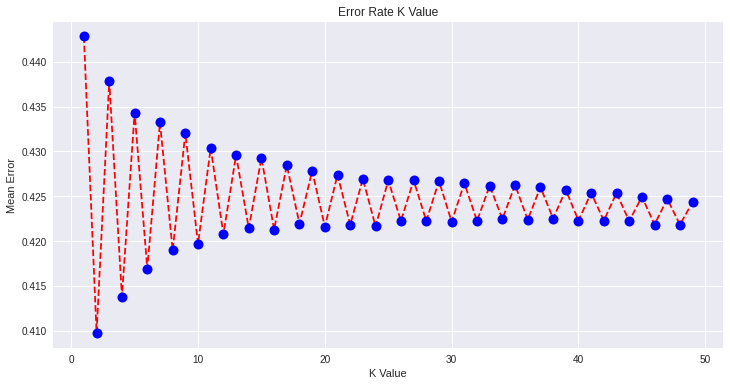

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(k_list, error0, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

PLOTTING ACCURACY VS K VALUE USED DATASET JET0

Text(0, 0.5, 'Accuracy')

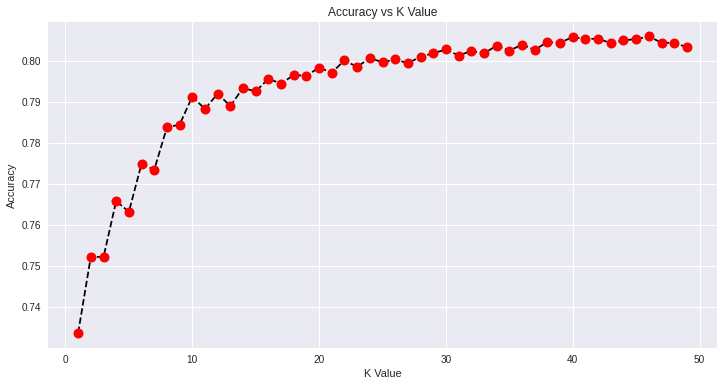

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, accuracy_knn0, color='black', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

## MODEL TRAINING FOR X_jet1

In [ ]:
%%time

accuracy_knn1= []
error1 = []

k_list = list(range(40,50))
for k in k_list:
    knn_1 = KNeighborsClassifier(n_neighbors=k)
    knncl_1 = Classifier(knn_1,X_train_u[1],X_val_u[1],y_train_u[1],y_val_u[1])
    y_pred_1 = knncl_1.give_preds()
    accuracy_knn1.append(knncl_1.give_accuracy())
    error1.append(np.mean(y_pred_1 != y_val_u[1].values))


print(f'the accuracy score for X_jet1 is {max(accuracy_knn1):.4f} for a value of k = {k_list[accuracy_knn1.index(max(accuracy_knn1))]}')

the accuracy score for X_jet0 is 0.7668891007308548 for a value of k = 43


PLOTTING ERROR RATE VS K VALUE USED FOR JET1 DATASET

Text(0, 0.5, 'Mean Error')

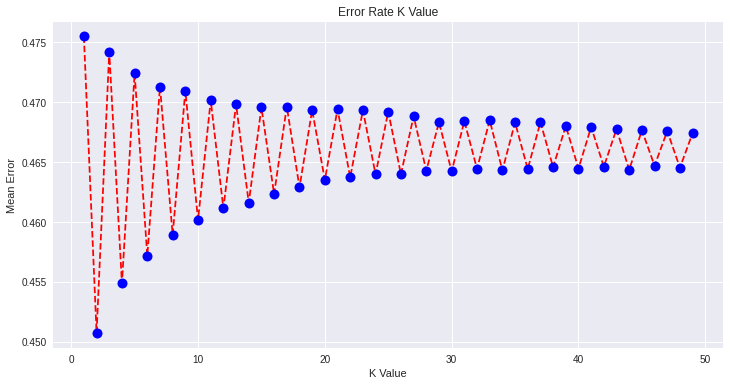

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, error1, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

PLOTTING ACCURACY VS K VALUE USED FOR JET1 DATASET

Text(0, 0.5, 'Accuracy')

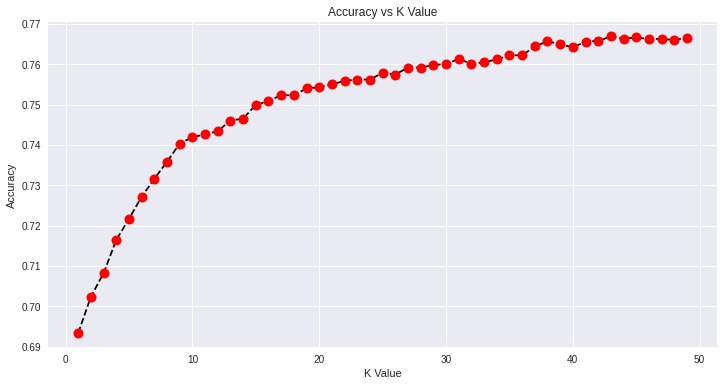

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, accuracy_knn1, color='black', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

## MAKING MODEL FOR X_jet2

In [ ]:
%%time

accuracy_knn2 = []
error2 = []

k_list = list(range(1,50))
for k in k_list:
    knn_2 = KNeighborsClassifier(n_neighbors=k)
    knncl_2 = Classifier(knn_2,X_train_u[2],X_val_u[2],y_train_u[2],y_val_u[2])
    y_pred_2 = knncl_2.give_preds()
    accuracy_knn2.append(knncl_2.give_accuracy())
    error2.append(np.mean(y_pred_2 != y_val_u[2].values))


print(f'the accuracy score for X_jet2 is {max(accuracy_knn2)} for a value of k = {k_list[accuracy_knn2.index(max(accuracy_knn2))]}')

the accuracy score for X_jet0 is 0.7706905394693897 for a value of k = 48


PLOTTING ERROR RATE VS K VALUE USED FOR JET2 DATASET

Text(0, 0.5, 'Mean Error')

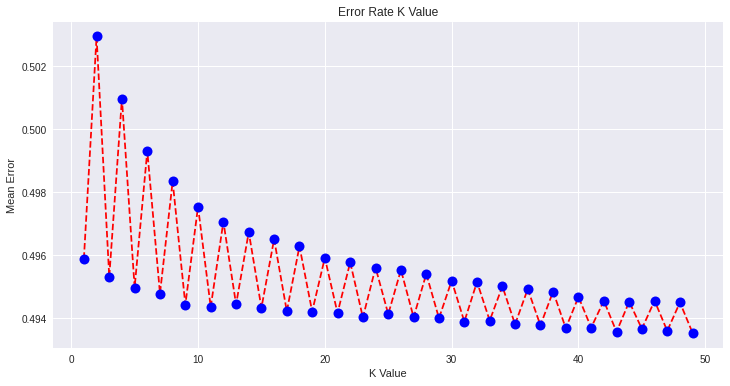

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, error2, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

PLOTTING ACCURCY VS K VALUE USED FOR JET2 DATASET

Text(0, 0.5, 'Accuracy')

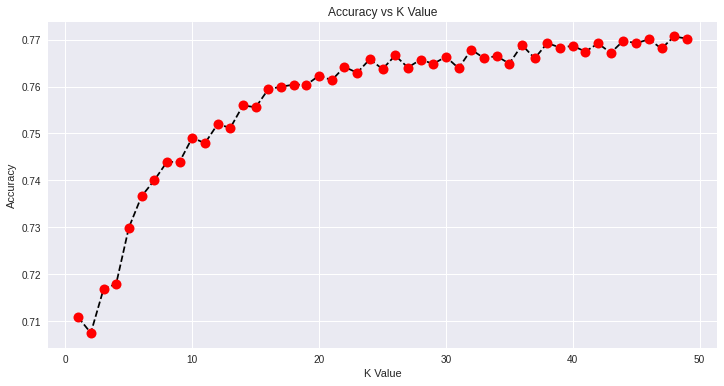

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, accuracy_knn2, color='black', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

## MODEL TRAINING FOR X_jet3 DATASET

In [ ]:
%%time

accuracy_knn3 = []
error3 = []

k_list = list(range(1,50))
for k in k_list:
    knn_3 = KNeighborsClassifier(n_neighbors=k)
    knncl_3 = Classifier(knn_3,X_train_u[3],X_val_u[3],y_train_u[3],y_val_u[3])
    y_pred_3 = knncl_3.give_preds()
    accuracy_knn3.append(knncl_3.give_accuracy())
    error3.append(np.mean(y_pred_3 != y_val_u[3].values))


print(f'the accuracy score for X_jet3 is {max(accuracy_knn3):.4f} for a value of k = {k_list[accuracy_knn3.index(max(accuracy_knn3))]}')

the accuracy score for X_jet0 is 0.742210242587601 for a value of k = 41


PLOTTING ERROR RATE VS K VALUE USED FOR JET3 DATASET

Text(0, 0.5, 'Mean Error')

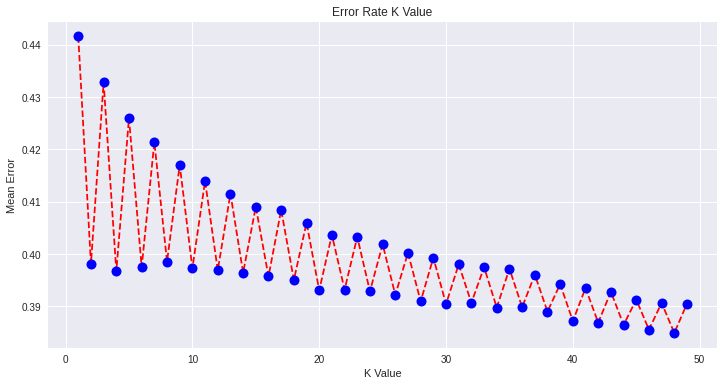

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, error3, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

PLOTTING ACCURACY VS K VALUE USED FOR JET3 DATASET

Text(0, 0.5, 'Accuracy')

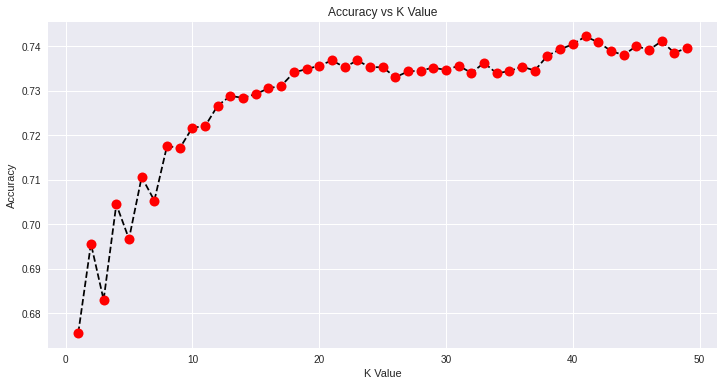

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, accuracy_knn3, color='black', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

## Final models of KNN and finding accuracy and Later AMS

In [ ]:
# looking at the accuracies in tabular form

pd.DataFrame([accuracy_knn3, accuracy_knn2, accuracy_knn1, accuracy_knn0],
    index=['Accuracy'], 
    columns=['dataset_jet0', 'dataset_jet1', 'dataset_jet2', 'dataset_jet3'])

In [ ]:
%%time

# DS -J0
#----------------------------------------------------------------------
# Finding the predictions for finding ams on validation datset
knn = KNeighborsClassifier(n_neighbors=46, n_jobs=-1)
    
knncl_0 = Classifier(knn,
                     X_train_u[0],
                     X_val_u[0],
                     y_train_u[0]['Label'],
                     y_val_u[0]['Label'])

y_pred_0 = knncl_0.give_preds()

# DS -J1
#----------------------------------------------------------------------
# Finding the predictions for finding ams on validation datset
knn = KNeighborsClassifier(n_neighbors=43, n_jobs=-1)
    
knncl_0 = Classifier(knn,
                     X_train_u[1],
                     X_val_u[1],
                     y_train_u[1]['Label'],
                     y_val_u[1]['Label'])

y_pred_1 = knncl_0.give_preds()

# DS -J2
#----------------------------------------------------------------------
# Finding the predictions for finding ams on validation datset
knn = KNeighborsClassifier(n_neighbors=48, n_jobs=-1)
    
knncl_0 = Classifier(knn,
                     X_train_u[2],
                     X_val_u[2],
                     y_train_u[2]['Label'],
                     y_val_u[2]['Label'])

y_pred_2 = knncl_0.give_preds()

# DS -J3
#----------------------------------------------------------------------
# Finding the predictions for finding ams on validation datset
knn = KNeighborsClassifier(n_neighbors=41, n_jobs=-1)
    
knncl_0 = Classifier(knn,
                     X_train_u[3],
                     X_val_u[3],
                     y_train_u[3]['Label'],
                     y_val_u[3]['Label'])

y_pred_3 = knncl_0.give_preds()

CPU times: total: 6min 16s
Wall time: 3min 23s


-------------------------------------------------

**A FUNCTION TO MEASURE AVERAGE MEDIAN SIGNIFICANCE OF THE VALIDATION DATA SET - CREATED A SEPARATE FILE -> 'evaluation_new.py'**

In [ ]:
def AMS(true_sol, pred_sol):
    """s = True Positive rate
    b = false positive rate
    
    true_sol must have these columns
    EventId - set as index
    Weights
    Label
    
    pred_sol must have these columns
    EventId - set as index
    predicted labels
    
    b_reg, b, s
    signal = s = 1
    background = b = 0"""
    
    import numpy as np
    import pandas as pd
    
    S = np.array(true_sol[true_sol['Label']==1].index)
    # print("Matching indexes of labels in solution and predictions for S = ", len(S))
    
    G_hat = np.array(pred_sol[pred_sol['Label']==1].index)
    # print("Matching indexes of labels in solution and predictions for predictions S= ", len(G_hat))
    
    S_intersection_G_hat = np.intersect1d(S, G_hat)
    # print(S_intersection_G_hat[:5])
    
    B = np.array(true_sol[true_sol['Label']==0].index)
    G_hat_b = np.array(pred_sol[pred_sol['Label']==0].index)
    
    B_intersection_G_hat_b = np.intersect1d(B, G_hat_b)
    
    s = np.sum(true_sol.loc[S_intersection_G_hat,'Weight'])
    
    b = np.sum(true_sol.loc[B_intersection_G_hat_b, 'Weight'])
    
    b_reg = 10
    
    val = (s+b+b_reg)  *  (np.log(1 + (s / (b + b_reg))))
    
    avg_med_sig = np.sqrt(2 * (val - s))
    
    return avg_med_sig

-------------------------------------------------

In [ ]:
# only if evaluation_new.py is in same folder - offline
# from evaluation_new import AMS

# Finding ams for all the predctions
y_val_u[3]
# pd.y_pred_3
pred_knn_y_0 = pd.DataFrame(y_pred_0, index=y_val_u[0].index, columns=['Label'])
pred_knn_y_1 = pd.DataFrame(y_pred_1, index=y_val_u[1].index, columns=['Label'])
pred_knn_y_2 = pd.DataFrame(y_pred_2, index=y_val_u[2].index, columns=['Label'])
pred_knn_y_3 = pd.DataFrame(y_pred_3, index=y_val_u[3].index, columns=['Label'])

pred_knn_y = pd.concat((pred_knn_y_0, pred_knn_y_1, pred_knn_y_2, pred_knn_y_3), axis=0)

# Finding the ams
# from evaluation_new import AMS

ams_knn = AMS(true_sol = true_solutions ,
              pred_sol = pred_knn_y)

print(f"AMS For overall validation data using KNN classification is {ams_knn:.4f}")

AMS For overall validation data using KNN classification is 0.5767


------------------------------------------

# LOGISTIC REGRESSION

### WORKFLOW / ALGORITHM FOR DECIDING C VALUES by cross validation

**STEP - 1**
- Make a list of C (penalty) values
- Make an empty list - this will store average scores of datasets per C value - test_score_per_c
- Loop through the C values list
    - Make an iterator that will iterate through dataset on demand (yield) - for both predictors and response vairable
    - Create an empty list - store mean cv scores of all data set for one C value - mean_sc_all_ds
    - Looping through the 4 datasets
        - Instantiate a logistic regression model
        - Using the cross_val_score find the test scores of ds using roc_auc.
        - Calculate mean of cv scores and store in a list - mean_sc_all_ds
    - Store list of 4 cv scores per dataset in a list - test_score_per_c
    
**STEP - 2**
Make a DataFrame for better look - tabular form

**STEP - 3**
Make a graph to see whcih c values gave better result

**STEP - 4**
Finding the best c values for per dataset.

### **Step - 1**

In [ ]:
#-------------------------------------------------------
# DOING LOGISTIC REGRESSION ON FULL DATA

# list of penalty values to apply in logistic regression
c_val = [0.0001,0.001,0.01,0.1,1,10,100]

# - Make an empty list - this will store average scores of datasets 
# per C value -> test_score_per_c
test_score_per_c = deque()

# - Loop through the C values list
for c in c_val:
    
    # - Make an iterator that will iterate through dataset on demand (yield) - 
    # for both predictors and response vairable
    all_X_iter = iter(X_dict.values())
    all_y_iter = iter(y_dict.values())
    
    # - Create an empty list - store mean 
    # cv scores of all data set for one C value - mean_sc_all_ds
    mean_sc_all_ds = list()
    
    # looping through datasets in the dictionary
    for i in range(4):
    
        # instantiating a model object
        lr = LogisticRegression(C=c, max_iter=5000, penalty = 'l2')
        
        # This calculate mean of cv score for one dataset
        # Never forget using ['Label'] for y
        mean_sc = np.mean(cross_val_score(lr, next(all_X_iter), next(all_y_iter)['Label'], cv=10, scoring='roc_auc'))
        
        # this will store mean scores and make list per c val
        mean_sc_all_ds.append(mean_sc)
        
    # this is storing the list of scores for 4 ds for one c_val
    test_score_per_c.append(mean_sc_all_ds)

### **Step - 2**

In [ ]:
# looking at the test_score_per_c for better understanding
print("C values are in index")

test_score_per_c = np.array(test_score_per_c)
pd.DataFrame(test_score_per_c, 
             columns = ['ds for jet0', 'ds for jet1', 'ds for jet2', 'ds for jet3'],
             index = c_val)

C values are in index


,ds for jet0,ds for jet1,ds for jet2,ds for jet3
0.0001,0.816694,0.739860,0.779168,0.698652
0.0010,0.836137,0.754573,0.798106,0.720568
0.0100,0.845279,0.758732,0.806386,0.735584
0.1000,0.845869,0.758903,0.807190,0.737924
1.0000,0.845849,0.758892,0.807244,0.738164
10.0000,0.845847,0.758892,0.807251,0.738176
100.0000,0.845847,0.758892,0.807251,0.738177


### **Step - 3**

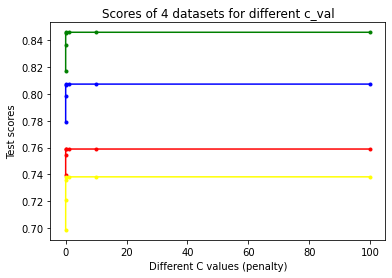

In [ ]:
# VISUALIZATION

# plt.style.use('seaborn-bright')

f,ax = plt.subplots()

ax.plot(c_val, test_score_per_c[:,0], color='green', marker='.')
ax.plot(c_val, test_score_per_c[:,1], color='red', marker='.')
ax.plot(c_val, test_score_per_c[:,2], color='blue', marker='.')
ax.plot(c_val, test_score_per_c[:,3], color='yellow', marker='.')
ax.set_title("Scores of 4 datasets for different c_val")
ax.set_xlabel("Different C values (penalty)")
ax.set_ylabel("Test scores")
# ax.set_ylim(0.2, 0.8)
# ax.set_xlim(-1,20)
# plt.savefig('Log_reg_c_vals_vs_accuracy.png')
plt.show()

### **Step - 4**

In [ ]:
# X_dict['X_jet0'].shape, X_dict['X_jet1'].shape, X_dict['X_jet2'].shape, X_dict['X_jet3'].shape

list_idx_best_c = np.argmax(test_score_per_c, axis=0)
best_c_per_ds = []
for i in list_idx_best_c:
    best_c_per_ds.append(c_val[i])
    
print(f"Best c for all data set respectively are\n", best_c_per_ds)

Best c for all data set respectively are
 [0.1, 0.1, 10, 100]


In [ ]:
%%time

accuracy_Lr = []
y_pred_Lr = []
for i in range(4):
  lr_all = LogisticRegression(max_iter=5000, random_state = 23)
  clfr_all = Classifier(lr_all,X_train_u[i],X_val_u[i],y_train_u[i]['Label'],y_val_u[i]['Label'])
  y_pred_Lr.append(clfr_all.give_preds())
  accuracy_Lr.append(clfr_all.give_accuracy())


  print(f'the accuracy score for X_jet{i} is {accuracy_Lr[i]*100:.4f}%')

the accuracy score for X_jet0 is 79.0326%
the accuracy score for X_jet1 is 69.2688%
the accuracy score for X_jet2 is 72.5913%
the accuracy score for X_jet3 is 71.9900%
CPU times: total: 1.84 s
Wall time: 1.29 s


## Finding Feature importance
- Problem - in 4 datasets all have different number of features

- possible solution - finding features importance for specific datasets stay limited to it.

## FINDING FEATURE IMPORTANCE USING BOOTSTRAPS - WORKFLOW / ALGORITHM FOR DECISION

**Step - 1**
- Decide the number of bootstraps
- Create a dictionary to store coefficients of all datasets over all boostraps -> all_coef
- Looping through total boostraps to be taken
    - Create iterators to yield datasets one by one from predefined training and validation dictionary of training and validation datasets - j0,j1,j2,j3
    - Loop through the 4 datasets
        - Merge training predictors dataset with training response dataset
        - Take sample using .sample() method of pandas
        - instantiate a Logistic Regression model
        - Fit the Sampled data
        - Find coefficients using attribute .coef_
        - Store coef list in respective list of that dataset ->all_coef

**Step - 2**

Create a new list to store mean of betas for every dataset

**Step - 3**

Make 4 plots to visualize the average coefficients over different bootstraps

**Step - 4**

OBSERVATIONS

----------------------------------

### Step - 1 & Step - 2

In [ ]:
#--------------------------------------------------------
# DOING BOOTSTRAPING TO FIND BEST FEATURES

# - Decide the number of bootstraps
numboot=50

# - Create a dictionary to store coefficients 
# of all datasets over all boostraps -> all_coef
all_coef = {'coef_ds_j0':[],
           'coef_ds_j1':[],
           'coef_ds_j2':[],
           'coef_ds_j3':[],}

# - Looping through total boostraps to be taken
for boot in range(numboot):
    # - Create iterators to yield datasets one by one from predefined training 
    # and validation dictionary of training and validation datasets - j0,j1,j2,j3
    iter_X_train_dict = iter(X_train_dict.values())
    iter_X_val_dict = iter(X_val_dict.values())
    iter_y_train_dict= iter(y_train_dict.values())
    iter_y_val_dict = iter(y_val_dict.values())
    iter_c = iter(best_c_per_ds)
    
    # - Loop through the 4 datasets
    for i in range(4):
        # - Merge training predictors dataset with training response dataset
        dta = pd.concat( (next(iter_X_train_dict), next(iter_y_train_dict)), 
                        axis=1 )
        
        # - Take sample using .sample() method of pandas
        sampled = dta.sample(frac=1, replace=True)
        
        # - instantiate a Logistic Regression model
        lr = LogisticRegression(C=next(iter_c),
                               max_iter = 5000)
        
        # Fit the sampled data
        lr.fit(sampled.drop(['Label'], axis=1), sampled['Label'])
        
        # Find the coefficients using attribute .coef_
        # Store coef list in respective list of that dataset -> all_coef
        all_coef[f'coef_ds_j{i}'].append(lr.coef_)


### Step - 3

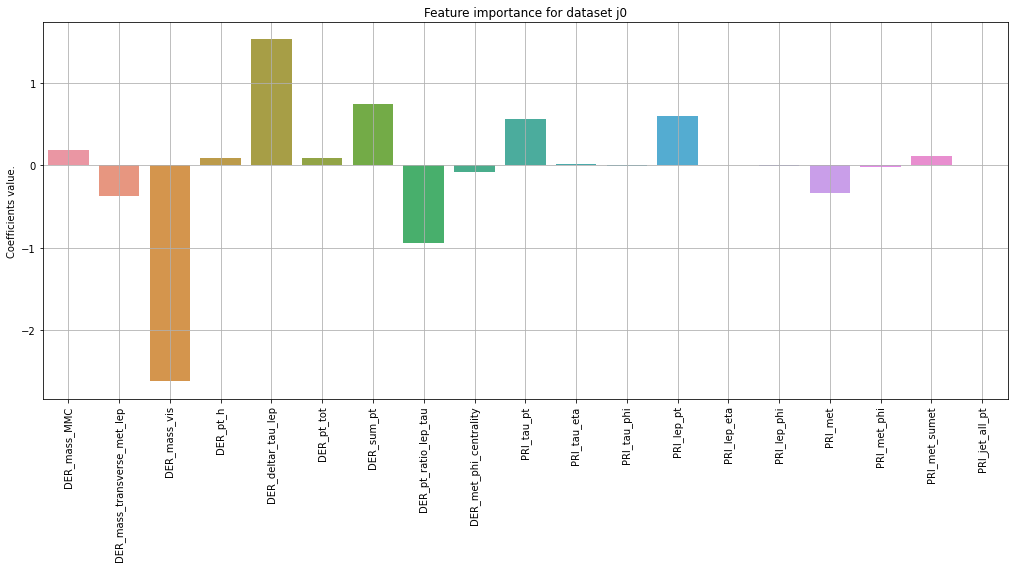

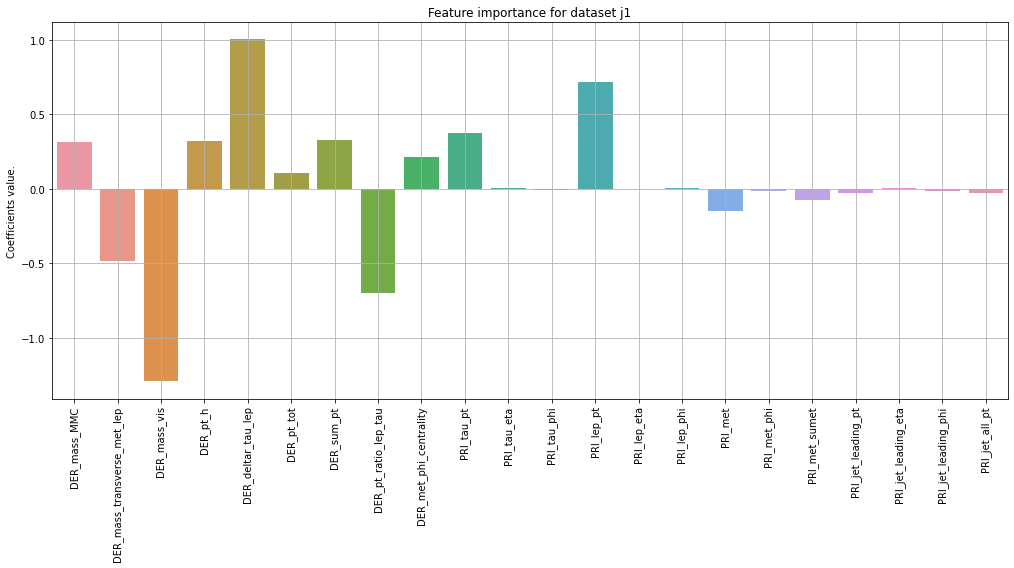

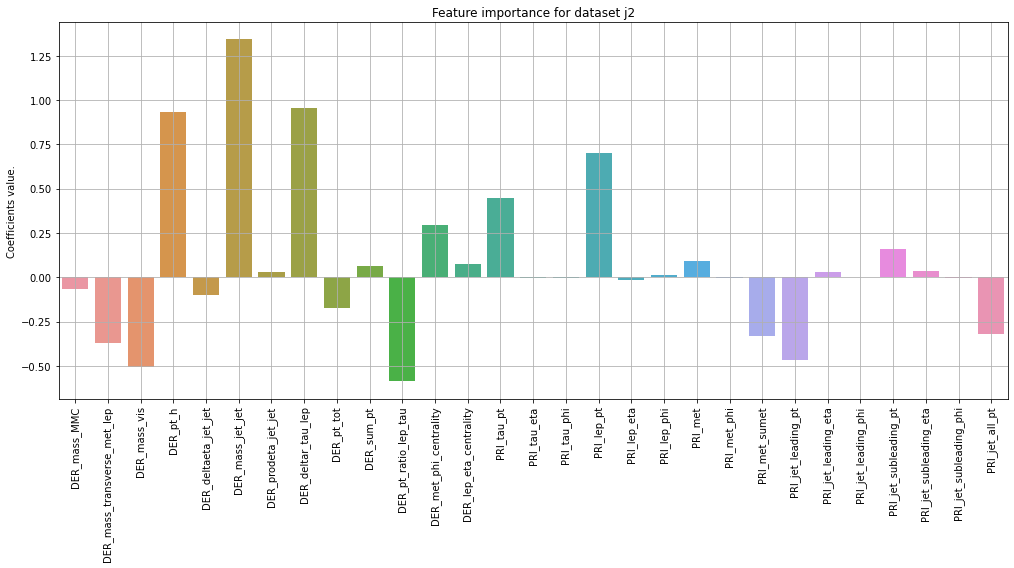

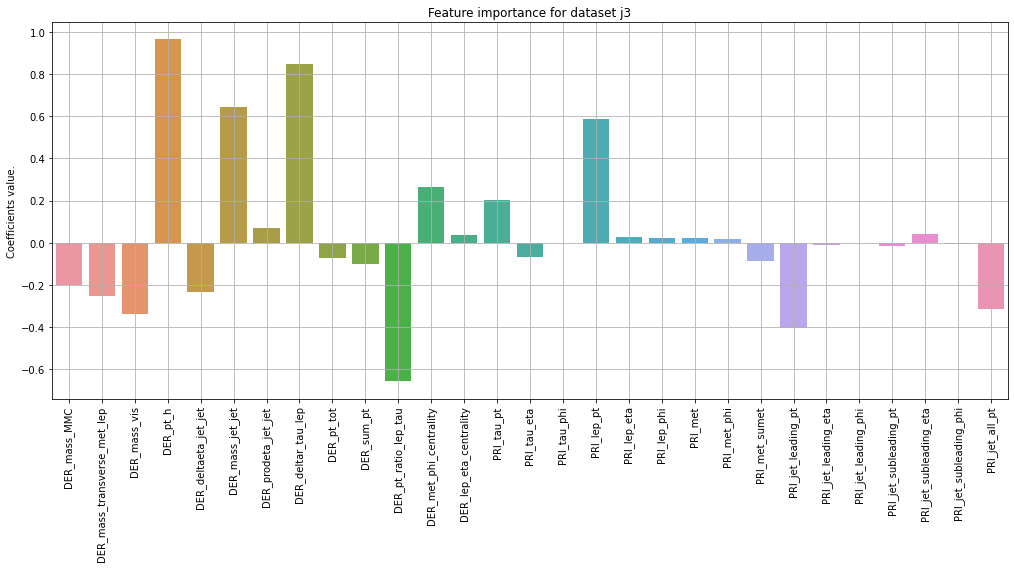

In [ ]:
# Create a new list to store mean of betas for every dataset
all_mean_coef = []

for list_coef in all_coef.values():
    all_mean_coef.append(np.array(list_coef).mean(axis=0))

# Make 4 plots to visualize the average coefficients over different boostraps
# plt.subplots(4,1, figsize=(14,40))

iter_X_train_dict = iter(X_train_dict.values())

for i in range(4):
    f,ax = plt.subplots(figsize=(14,8))
    # ax = plt.subplot(4,1,i+1)
    cols = next(iter_X_train_dict).columns
    sbn.barplot( x = cols, y = all_mean_coef[i][0] , ax=ax)
    plt.xticks(rotation=90)
    plt.title(f"Feature importance for dataset j{i}")
    plt.grid(True)
    f.tight_layout()
    plt.ylabel("Coefficients value.")
    # plt.savefig(f'Logistic_regr_Feature_import_ds_j{i}.png')
    plt.show()

### Observations
- Few columns that are seems important in all dataset. Following code is finding it and printing it

In [ ]:

# a nested list to store index numbers of betas which has absolute value greater than 0.1
ft_imp_coef_idx = [ [], [], [], []]

for idx in range(len(all_mean_coef)):
    for i in range(len(all_mean_coef[idx][0])):
        if np.abs(all_mean_coef[idx][0][i]) > 0.1:
            ft_imp_coef_idx[idx].append(i)
            
# print(ft_imp_coef_idx)

# a nested list to save the names of columns that have coefficients above the absolute value 0.1
ft_imp_col_names = [ [], [], [], [], ]

# making an iterator to get columns of each dataset
iter_X_train_dict = iter(X_train_dict.values())

# a loop to loop through the 4 datasets
for idx in range(4):
    
    # assigning a dataset to a variable
    ds = next(iter_X_train_dict)
    print(f"For dataset j{idx} following are the important features (threshold -> absolute of betas > 0.1)")
    
    # looping through the list in ft_imp_coef_idx one by one to get 
    # column names and store them in a nested list for storing names
    for i in ft_imp_coef_idx[idx]:
        ft_imp_col_names[idx].append(ds.columns[i])
        print(ds.columns[i])
    print()


For dataset j0 following are the important features (threshold -> absolute of betas > 0.1)
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_deltar_tau_lep
DER_sum_pt
DER_pt_ratio_lep_tau
PRI_tau_pt
PRI_lep_pt
PRI_met
PRI_met_sumet

For dataset j1 following are the important features (threshold -> absolute of betas > 0.1)
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
PRI_tau_pt
PRI_lep_pt
PRI_met

For dataset j2 following are the important features (threshold -> absolute of betas > 0.1)
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_mass_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_pt_ratio_lep_tau
DER_met_phi_centrality
PRI_tau_pt
PRI_lep_pt
PRI_met_sumet
PRI_jet_leading_pt
PRI_jet_subleading_pt
PRI_jet_all_pt

For dataset j3 following are the important features (threshold -> absolute of betas > 0.1)
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltae

------------------------------------------

### Final model found in Logistic regression then ams

In [ ]:
#------------------------------------------------------------------------
# This was inside for loop above

# makaing a data frame so that it can work with AMS function
# preds = pd.DataFrame(preds['Label'], 
#                      index=preds['EventId'],
#                     columns=['Label'])

# ams_list.append(AMS(true_sol=true_solutions, pred_sol=preds))
#------------------------------------------------------------------------
iter_X_train_dict = iter(X_train_dict.values())
iter_X_val_dict = iter(X_val_dict.values())
iter_y_train_dict= iter(y_train_dict.values())
# iter_y_val_dict = iter(y_val_dict.values())
iter_c = iter(best_c_per_ds)

predictions = list()

acc_lr_ds = list()

# - Loop through the 4 datasets
for i in range(4):
    # - Merge training predictors dataset with training response dataset
    pred_X = next(iter_X_train_dict)
    target_y = next(iter_y_train_dict)
    val_X = next(iter_X_val_dict)
    val_y = next(iter_y_val_dict)
    
    # - instantiate a Logistic Regression model
    lr = LogisticRegression(C=next(iter_c),
                           max_iter = 5000)

    # Fit the sampled data
    lr.fit(pred_X, target_y['Label'])
    
    # finding predicitons
    predictions.append( pd.DataFrame(lr.predict(val_X), columns=['Label'], index=val_y.index ) )
    
    # finding the accuracies for all 4 datasets
    acc_lr_ds.append(lr.score(val_X, val_y))
    
predictions = pd.concat(predictions, axis=0)


In [ ]:
# printing the accuracy score of model over a validation datast
for i, ac in enumerate(acc_lr_ds):
    print(f"The accuracy score of best Logisitic Regression models over validation dataset jet{i} is {ac:.4f}")

------------------------------------------

### Make AMS Report

In [ ]:
# There is a file evaluation_new in which we made a AMS function for evaluation
# from evaluation_new import AMS

evaluation = AMS(true_sol=true_solutions, pred_sol=predictions)

print("We did evaluation using AMS on validation dataset of all 4 dataset.")
print(f"The combined AMS found is {evaluation:.4f}")

We did evaluation using AMS on validation dataset of all 4 dataset.
The combined AMS found is 0.5249


------------------------------------------

## DECISION TREE CLASSIFIERS - DECIDING MAX_DEPTH FOR EACH DATASET BY USING CROSS VALIDATION

### ALGORITHM / WORKFLOW

**Step - 0**
- Create a empty list to store all the cross validation scores over different max_depth
- Create a list to store range of max_depths values wanting to pass
- Loop through the depths
    - create an iterator to iterate through all 4 whole dataset
    - create an empty list to store mean scores of cross validation of 4 datasets
    - Loop through 4 datasets and then
        - Instantiate a model object
        - Do the cross validation cv =10, using 'roc_auc' scoring metric
        - find the mean store the mean in -> mean_scores_per_ds
    - Store the list of mean scores for this specific tree depth in a list -> score_per_depth
    
**Step - 1**

Looking at the collected accuracies at different depths in dataframe

**Step - 2**

Making a plot for better visualizations

**Step - 3**

Finding the best max_depth of each dataset and storing in a list

## Step - 1

In [ ]:
%%time
#----------------------------------------------------------------------------
# DECISION TREE CLASSIFIER

# HYPERP - max_depth, class_weight, 
# max_depth 2 to 10
# class_weight - balanced and None

# Deciding max_depth using cross_validator

# create a list to store range of tree depths
depths = list(range(2,15))

# An empty list to store mean scores of cv per dataset
score_per_depth = []

# loop through the number of depths
for dep in depths:
    
    # Creating iterators to iterate through datasets
    iter_X_dict = iter(X_dict.values())
    iter_y_dict = iter(y_dict.values())
    
    # a list to store mean cv scores of each dataset
    mean_scores_per_ds = []
    # looping though the datasets to find respective best max_depth hyperparameter
    for i in range(4):
        dt = DecisionTreeClassifier(max_depth=dep, class_weight='balanced')
        
        # The scoring can be changed to - 'f1', 'accuracy', 'average_precision',
        # 'precision', 'recall'
        cv_test = cross_val_score(dt,
                                 next(iter_X_dict),
                                 next(iter_y_dict),
                                 cv=10, scoring='roc_auc')
        
        mean_scores_per_ds.append(np.mean(cv_test))
    
    # storing the mean scores of specific depth in a list
    score_per_depth.append(mean_scores_per_ds)

CPU times: total: 9min 57s
Wall time: 10min 17s


## Step - 2

In [ ]:
# data frame for better look at tabular data
print("Depths is Index")
pd.DataFrame(score_per_depth, index=depths, columns = ['ds_j0','ds_j1','ds_j2','ds_j3',])

Depths is Index


,ds_j0,ds_j1,ds_j2,ds_j3
2,0.775400,0.755895,0.784753,0.794790
3,0.807112,0.804609,0.847411,0.832481
4,0.828065,0.830674,0.867897,0.852310
5,0.844285,0.843779,0.884678,0.864206
6,0.851509,0.849994,0.891549,0.864496
7,0.855935,0.853679,0.894697,0.862340
8,0.856324,0.853792,0.893751,0.855631
9,0.852126,0.850385,0.889309,0.842038
10,0.843656,0.842108,0.878509,0.825701
11,0.832546,0.829639,0.862307,0.811574


## Step - 3

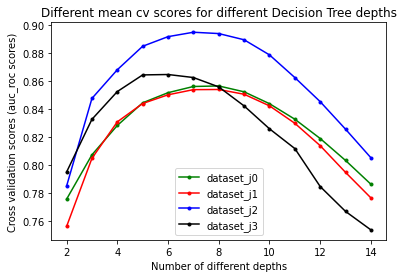

In [ ]:
# Making graph for visualization
score_per_depth = np.array(score_per_depth)
f, ax = plt.subplots()

ax.plot(depths, score_per_depth[:, 0], color='green', marker='.', label='dataset_j0')
ax.plot(depths, score_per_depth[:, 1], color='red', marker='.', label='dataset_j1')
ax.plot(depths, score_per_depth[:, 2], color='blue', marker='.', label='dataset_j2')
ax.plot(depths, score_per_depth[:, 3], color='black', marker='.', label='dataset_j3')

ax.set_xlabel('Number of different depths')
ax.set_ylabel("Cross validation scores (auc_roc scores)")
ax.set_title("Different mean cv scores for different Decision Tree depths")
ax.legend()
# plt.savefig(f'DecisionTreeClassifier_auc_roc_score_max_depth.png')
plt.show()

## Step - 4

In [ ]:
# finding the best max_depths and storing in a list
idx = np.argmax(score_per_depth, axis=0)

best_max_depths = []
for i in idx:
    best_max_depths.append(depths[i])
    
print(f"The best max_depth found for respective datasets are\n", best_max_depths)

The best max_depth found for respective datasets are
 [8, 8, 7, 6]


# DECISION TREE CLASSIFIERS - DOING BOOTSTRAPPING TO FIND FEATURE IMPORTANCE

## ALGORITHM / WORKFLOW
**Step - 1**
- Decide the number of bootstraps to perform
- create a list of dictionaries, the dicitonaries will have values storing feature importance for the Decision Tree Classifier - `all_ft_impt`
- Loop through as many times as the boostrap numbers
    - Make iterators for trianing and validation datasets - these will iterate through 4 datasets
    - make an iterator to iterate the best max_depth found for each dataset.
    - make a loop to loop through 4 datasets
        - Concate the response and predictors for training set
        - make new sample for the concated dataset.
        - instantiate the decision tree classifier model object
        - fit the model on the sample set
        - find the feature importance and append it to the values in dictionary created earlier. use inbuilt attribute of decision tree classifier `feature_importance_`

**Step - 2**
- Find the mean of columns in each value in dictionary `all_ft_impt`

**Step - 3**
- visualizing the mean feature importances found using bar plot.

**Observation**

**Final Model**

**Finding the AMS over final model ( validaiton dataset ) for evaluation**

### Step - 1

In [ ]:
%%time

numboot = 20

all_ft_impt = {'ft_imp_ds_j0':[],
              'ft_imp_ds_j1':[],
              'ft_imp_ds_j2':[],
              'ft_imp_ds_j3':[],}

for boot in range(numboot):
    # - Create iterators to yield datasets one by one from predefined training 
    # and validation dictionary of training and validation datasets - j0,j1,j2,j3
    iter_X_train_dict = iter(X_train_dict.values())
    iter_X_val_dict = iter(X_val_dict.values())
    iter_y_train_dict= iter(y_train_dict.values())
    iter_y_val_dict = iter(y_val_dict.values())
    iter_dep = iter(best_max_depths)
    
    # - Loop through the 4 datasets
    for i in range(4):
        # - Merge training predictors dataset with training response dataset
        dta = pd.concat( (next(iter_X_train_dict), next(iter_y_train_dict)), 
                        axis=1 )
        
        # - Take sample using .sample() method of pandas
        sampled = dta.sample(frac=1, replace=True)
        
        # - instantiate a Logistic Regression model
        dt = DecisionTreeClassifier(max_depth=next(iter_dep), class_weight='balanced')
        
        # Fit the sampled data
        dt.fit(sampled.drop(['Label'], axis=1), sampled['Label'])
        
        # Find the coefficients using attribute .coef_
        # Store coef list in respective list of that dataset -> all_coef
        all_ft_impt[f'ft_imp_ds_j{i}'].append(dt.feature_importances_)

CPU times: total: 1min 4s
Wall time: 1min 6s


### Step - 2

In [ ]:
# Create a new list to store mean of importances for every dataset
all_mean_ft_imp = []

for list_imp in all_ft_impt.values():
    all_mean_ft_imp.append(np.array(list_imp).mean(axis=0))

In [ ]:
# all_mean_ft_imp

### Step - 3

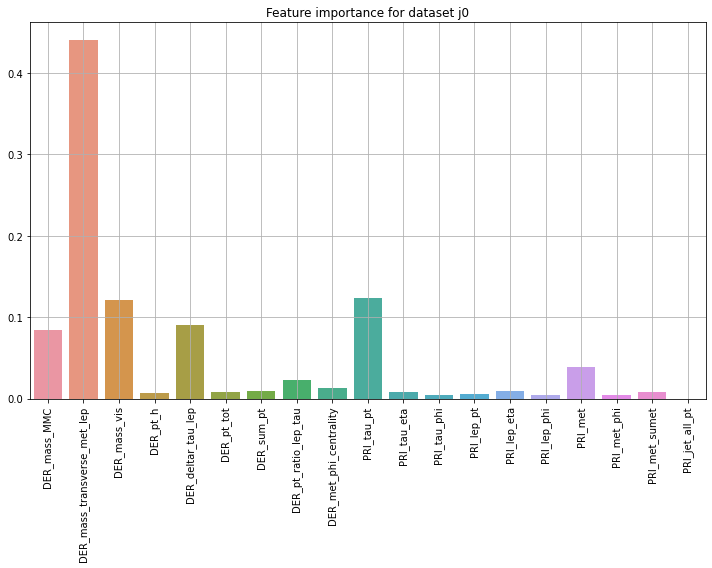

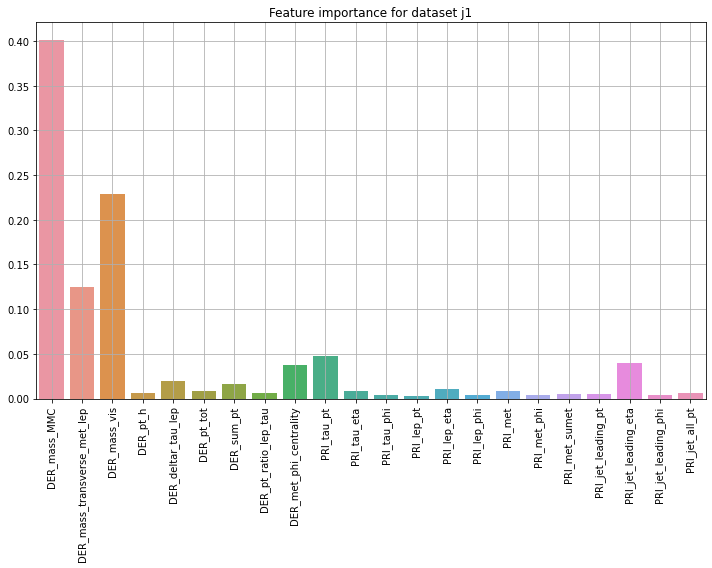

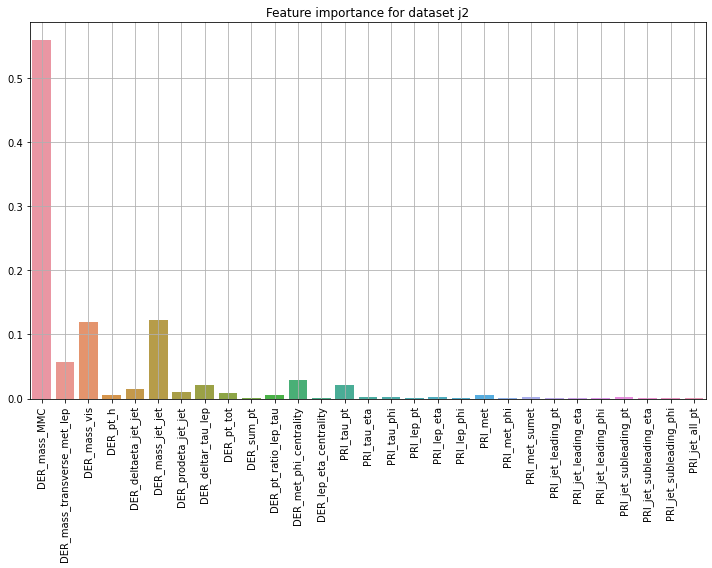

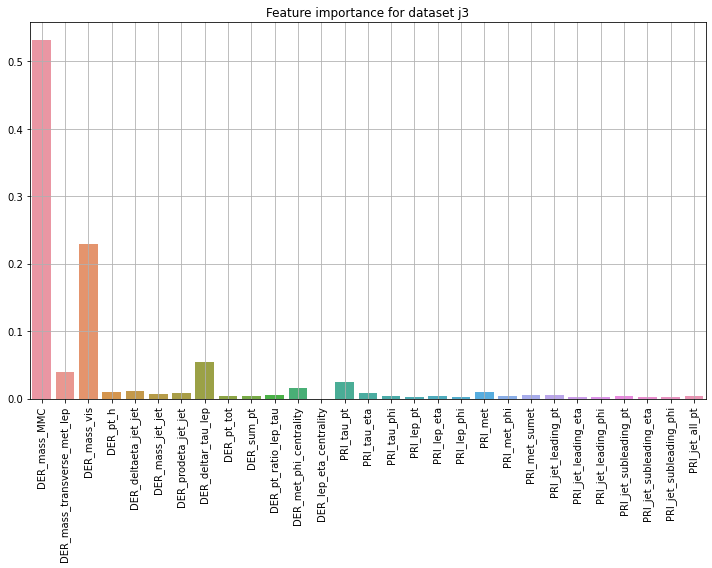

In [ ]:
# Make 4 plots to visualize the average coefficients over different boostraps

iter_X_train_dict = iter(X_train_dict.values())

for i in range(4):
    f, ax = plt.subplots(figsize=(10,8))
    
    cols = next(iter_X_train_dict).columns
    sbn.barplot( x = cols, y = all_mean_ft_imp[i], ax=ax)
    plt.xticks(rotation=90)
    plt.title(f"Feature importance for dataset j{i}")
    plt.tight_layout()
    plt.grid(True)
    # plt.savefig(f'DecisionTreeClassifier_feature_importance_ds_j{i}.png')
    plt.show()

### OBSERVATION
- Compared to Logistic regression only a few features are given importance
- Commonly they are
    - DER_mass_MMC
    - DER_mass_trasverse_met_lep
    - DER_mass_vis
    - DER_deltar_tau_lep
    - DER_mass_jet_jet

### Final Decision Tree Classifier

In [ ]:
%%time
#------------------------------------------------------------------------

iter_X_train_dict = iter(X_train_dict.values())
iter_X_val_dict = iter(X_val_dict.values())
iter_y_train_dict= iter(y_train_dict.values())
iter_y_val_dict = iter(y_val_dict.values())
iter_dep = iter(best_max_depths)

predictions = list()

accu_dt = []

# - Loop through the 4 datasets
for i in range(4):
    # - Merge training predictors dataset with training response dataset
    pred_X = next(iter_X_train_dict)
    target_y = next(iter_y_train_dict)
    val_X = next(iter_X_val_dict)
    val_y = next(iter_y_val_dict)
    
    # - instantiate a Logistic Regression model
    dt = DecisionTreeClassifier(max_depth=next(iter_dep))

    # Fit the sampled data
    dt.fit(pred_X, target_y['Label'])
    
    # finding predicitons
    predictions.append( pd.DataFrame(dt.predict(val_X), columns=['Label'], index=val_y.index ) )
    
    # finding the accuracy score for each dataset.
    accu_dt.append( dt.score(val_X, val_y) \
                  )
    
predictions = pd.concat(predictions, axis=0)


CPU times: total: 3.2 s
Wall time: 3.32 s


In [ ]:
print(predictions.head(10))

print("\nShape of all predictions of validation dataset is ", predictions.shape)
print()
for i, ac in enumerate(accu_dt):
    print(f"The accuracy score of Decision Tree Classifier validation dataset jet{i} is {ac:.4f}")

         Label
EventId       
100003       0
100008       0
100015       0
100021       0
100025       0
100037       0
100043       0
100054       0
100055       0
100058       0

Shape of all predictions of validation dataset is  (95084, 1)

The accuracy score of Decision Tree Classifier validation dataset jet0 is 0.7985
The accuracy score of Decision Tree Classifier validation dataset jet1 is 0.7850
The accuracy score of Decision Tree Classifier validation dataset jet2 is 0.8110
The accuracy score of Decision Tree Classifier validation dataset jet3 is 0.8107


### Finding the AMS of validation dataset

In [ ]:
%%time

# There is a file evaluation_new in which we made a AMS function for evaluation
# from evaluation_new import AMS


evaluation = AMS(true_sol=true_solutions, pred_sol=predictions)

print("We did evaluation using AMS on validation dataset of all 4 dataset.")
print(f"The combined AMS found is {evaluation:.4f}")

We did evaluation using AMS on validation dataset of all 4 dataset.
The combined AMS found is 0.6022
CPU times: total: 62.5 ms
Wall time: 80 ms


# RANDOM FOREST CLASSIFIER

## WORKFLOW / ALGORITHM

**Step - 1**
- Make two iterators to iterate through the predictors and target variable datasets.
- Make an empty list to store the best estimators found by using grid search for each dataset.
- Loop 4 times as we have 4 datasets
    - Instantiate a model object
    - Create a dictionary which contains the hyperparameters as the keys and their values on which gird searching is to be performed.
    - Make a grid search class object and pass the arguments and kwargs.
    - Fit the data to the grid search object.
    - Find the best Estimator by using `best_estimator_` and append in an empty list created previously

**Step - 2**

- Training each dataset using the best model found.

**Step - 3**
- visualizing the permutation feature importance found

**Step - 4**
- Evaluating the above trained model by finding AMS for Validation set

### Step - 1

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
#----------------------------------------------------------------------------
# RANDOM FOREST CLASSIFIER

# HYPERP - max_depth, class_weight, n_estimators
# max_depth 2 to 10
# class_weight - balanced - using this from the result above
# n_estimators
    
# Creating iterators to iterate through datasets
iter_X_dict = iter(X_dict.values())
iter_y_dict = iter(y_dict.values())

# a list to store mean cv scores of each dataset
# mean_scores_per_ds = []
best_estimator_list = []

# looping though the datasets to find hyperparameters
for i in range(4):

    # Instantiate a model object
    dt = RandomForestClassifier(n_jobs=-1)

    # making a parameter dictionary that we will be grid searching with
    param = {'max_depth': list(range(2,11)),
            'n_estimators':[100]}
    
    # Creating a grid search class object
    gs = GridSearchCV(dt, 
                      param, 
                      scoring='roc_auc',
                      n_jobs=-1,
                      cv=10,
                      verbose=2 )

    # fitting the training data
    gs.fit( next(iter_X_dict), next(iter_y_dict)['Label'] )

    best_estimator_list.append(gs.best_estimator_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
CPU times: total: 1min 53s
Wall time: 25min 43s


In [ ]:
# looking at the best estimators found by grid searching
for b in best_estimator_list:
    print(b)

RandomForestClassifier(max_depth=10, n_jobs=-1)
RandomForestClassifier(max_depth=10, n_jobs=-1)
RandomForestClassifier(max_depth=10, n_jobs=-1)
RandomForestClassifier(max_depth=10, n_jobs=-1)


--------------------------------------

### Step - 2

In [ ]:
%%time

# making iterator to iter through the datasets in training and validation dictionary

iter_X_train_dict = iter(X_train_dict.values())
iter_X_val_dict = iter(X_val_dict.values())
iter_y_train_dict= iter(y_train_dict.values())
iter_y_val_dict = iter(y_val_dict.values())

# an empty list to store predictions on validation dataset.
predictions = []

# An empty list to store feature importance of separate models
ft_im_rf = []

# making an empty list to store accuracy score for each dataset
accuracy_per_ds = []

# looping through the best estimators
for b in best_estimator_list:

    # b is the best model for dataset
    model = b

    # fitting the model
    model.fit( next(iter_X_train_dict), next(iter_y_train_dict)['Label'])

    # appending the feature importances in a list
    ft_im_rf.append(model.feature_importances_)

    y_val_ds = next(iter_y_val_dict)
    X_val_ds = next(iter_X_val_dict)
    # appending the dataframes in an emoty list created previously 
    # so that we can find AMS later
    predictions.append( pd.DataFrame(model.predict(X_val_ds), 
                                                   index = y_val_ds.index, 
                                                   columns=['Label']) )
    accuracy_per_ds.append( model.score(X_val_ds, y_val_ds) )
    
# concat the dataframes in a list
predictions = pd.concat(predictions, axis=0)

CPU times: total: 1min 21s
Wall time: 26.9 s


In [ ]:
# printing the accuracy scores of respective datasets.
for i, sc in enumerate(accuracy_per_ds):
    print(f"The accuracy score for training set of dataset jet{i} is {sc*100:.4f}")

The accuracy score for training set of dataset jet0 is 81.6112
The accuracy score for training set of dataset jet1 is 79.7633
The accuracy score for training set of dataset jet2 is 83.1530
The accuracy score for training set of dataset jet3 is 83.6618


### Step - 3

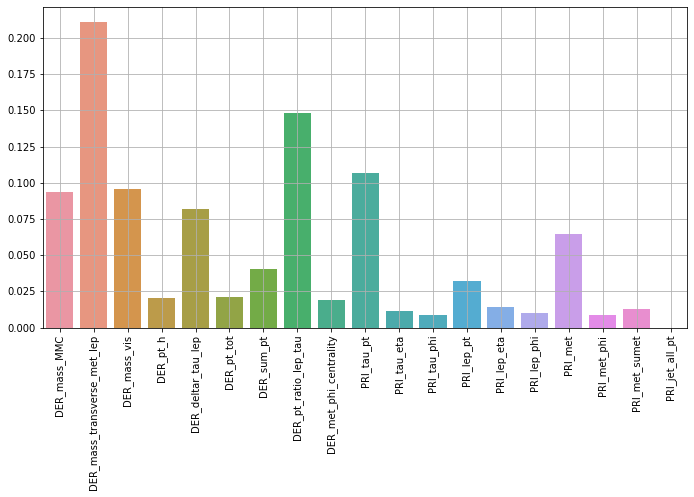

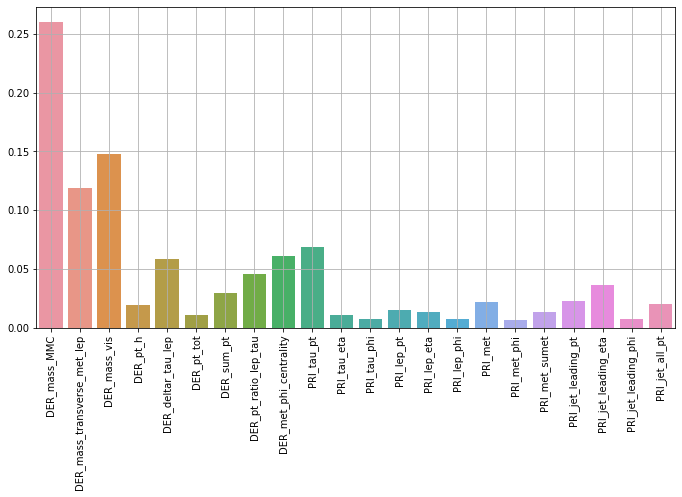

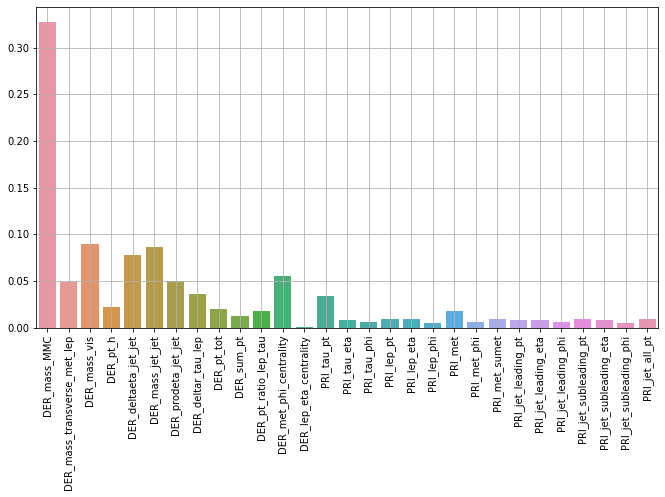

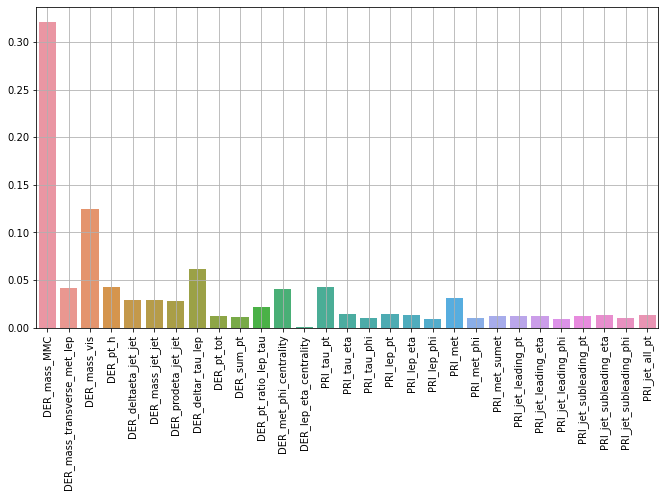

In [ ]:
# making an iterator to fetch column names from each dataset
iter_X_train_dict = iter(X_train_dict.values())

# making a plot in loop .
for i in range(4):
    f, ax = plt.subplots(figsize=(10,5))
    cols = next(iter_X_train_dict).columns
    
    sbn.barplot(ax=ax, y=ft_im_rf[i], x=cols)
    ax.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=90)
    # plt.savefig(f'FeatureImp_random_forest_ds_jet{i}')
    plt.show()

### Step - 4

In [ ]:
# Finding the ams for validation set
ams_rf = AMS(true_sol = true_solutions,
             pred_sol = predictions)

print(f"The AMS for Random Forest Classifier on validation set is {ams_rf:.4f}")

The AMS for Random Forest Classifier on validation set is 0.6022


# GRADIENT BOOSTING CASSIFIER

### Step - 1

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
#----------------------------------------------------------------------------
# Gradient Boosting CLASSIFIER

# HYPERP - max_depth, class_weight, n_estimators
# max_depth 2 to 10
# class_weight - balanced - using this from the result above
# n_estimators
    
# Creating iterators to iterate through datasets
iter_X_train_dict = iter(X_train_dict.values())
iter_X_val_dict = iter(X_val_dict.values())
iter_y_train_dict= iter(y_train_dict.values())
iter_y_val_dict = iter(y_val_dict.values())

# creating an empty list to store the predictions
predictions = []

# empty list to store accuracy scores of all models
accuracy_sc_per_ds = []

# looping though the datasets to train model
for i in range(4):
    X_train_ds = next(iter_X_train_dict)
    y_train_ds = next(iter_y_train_dict)
    X_val_ds = next(iter_X_val_dict)
    y_val_ds = next(iter_y_val_dict)

    # Instantiate a model object
    # gbc = GradientBoostingClassifier(n_iter_no_change = 5)
    gbc = GradientBoostingClassifier(n_estimators=200)
    
    gbc.fit(X_train_ds, y_train_ds['Label'])

    # appending the dataframes to facilitate ams calculation later
    predictions.append( 
        pd.DataFrame(gbc.predict(X_val_ds), index=y_val_ds.index, columns=['Label']) 
    )

    accuracy_sc_per_ds.append(gbc.score(X_val_ds, y_val_ds['Label']))

predictions = pd.concat(predictions, axis=0)

CPU times: total: 4min 16s
Wall time: 4min 24s


In [ ]:
# DELETE LATER
# The GBC with n_estimator 200 is performing better but how to know that it has not overfit?

In [ ]:
# printing the predictions
for i, ac in enumerate(accuracy_sc_per_ds):
    print(f"The accuracy score for the GRadient Boosting Classifier dataset jet{i} is {ac:.4f}")

The accuracy score for the GRadient Boosting Classifier dataset jet0 is 0.8150
The accuracy score for the GRadient Boosting Classifier dataset jet1 is 0.8063
The accuracy score for the GRadient Boosting Classifier dataset jet2 is 0.8373
The accuracy score for the GRadient Boosting Classifier dataset jet3 is 0.8401


In [ ]:
# finding the AMS over different validation datasets
ams_gbc = AMS(true_sol = true_solutions,
              pred_sol = predictions)

print(f"The AMS of Gradient Boost Classifier over validation set is {ams_gbc:.4f}")

The AMS of Gradient Boost Classifier over validation set is 0.6186
